# Predicting Log Error from Zillow's Zestimate


## Introduction
Zillow's Zestimate is quite good at predicting the value of a property, but there is still some error. For each prediction made, Zillow calculated the log error of that prediction. Log error is the difference between the log of the Zestimate and the log of the actual sales price. Knowing how log error performs can help improve the predictive power of the original model. For example, if the log error of the original model was always 0.010, the original model could be consistently adjusted for that constant, and the original model would improve to a perfect prediction accuracy. 

In this project, we will be investigating how log error changes based on the characteristic features of each property in the Zillow database, and attempt to produce a model that can reliably predict log error. 

We will move through the following steps of the data science pipeline to reach our goal:
1. Acquisition and Preparation
2. Exploration
3. Feature Selection
4. Modeling
5. Conclusion

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import math

import acquire
import explore
from sklearn.cluster import KMeans

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Selection 
from sklearn.feature_selection import SelectKBest, RFE

# Modeling
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Acquiring and Preparing the Data
A dataframe is acquired from Codeup's SQL zillow database using the `prepare_zillow()` function from acquire.py. 

`prepare_zillow()` returns a dataframe split into train, validate, and test based on the requirements detailed in the README.

In summary:
1. Data was obtained from Codeup's SQL database.
2. Categorical variables encoded as numeric data types are converted to object type.
3. fips codes were converted into county names.
4. Outliers were compressed (excluding log error).
5. Missing values were dropped or imputed with the mean, median, or mode.

In [2]:
train, validate, test = acquire.prepare_zillow()

In [3]:
#Observe the size of each set
train.shape, validate.shape, test.shape

((52518, 25), (13130, 25), (7295, 25))

In [4]:
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
48285,2.0,2.0,4.000000,1170.0,Los Angeles,2.0,7.0,33876919.0,-118405108.0,2258.0,...,1916.0,38403.0,294146.0,255743.0,3376.55,6.03762e+13,0.163588,2017-06-27,Floor/Wall,Single Family Residential
4918,3.0,2.0,7.000000,1827.0,Los Angeles,3.0,2.0,33765300.0,-118172000.0,15018.0,...,1970.0,360413.0,604073.0,243660.0,7207.01,6.03758e+13,0.049248,2017-01-25,Central,Condominium
14238,3.0,3.0,8.000000,1949.0,Los Angeles,3.0,2.0,34111771.0,-117748974.0,3317.0,...,1980.0,106726.0,177748.0,71022.0,2210.76,6.0374e+13,0.041176,2017-03-07,Central,Planned Unit Development
33467,3.0,4.0,6.639845,1835.0,Ventura,3.0,2.0,34181577.0,-118953714.0,6098.0,...,1974.0,160407.0,267340.0,106933.0,2801.20,6.11101e+13,0.089397,2017-05-11,Central,Condominium
22026,3.0,3.0,4.000000,1287.0,Los Angeles,3.0,2.0,33802256.0,-118187611.0,6255.0,...,1922.0,159987.0,338075.0,178088.0,4171.91,6.03757e+13,0.035123,2017-04-04,Central,Single Family Residential


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52518 entries, 48285 to 12816
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   52518 non-null  float64
 1   bedroomcnt                    52518 non-null  float64
 2   buildingqualitytypeid         52518 non-null  float64
 3   calculatedfinishedsquarefeet  52518 non-null  float64
 4   fips                          52518 non-null  object 
 5   fullbathcnt                   52518 non-null  float64
 6   heatingorsystemtypeid         52518 non-null  float64
 7   latitude                      52518 non-null  float64
 8   longitude                     52518 non-null  float64
 9   lotsizesquarefeet             52518 non-null  float64
 10  propertycountylandusecode     52518 non-null  object 
 11  propertylandusetypeid         52518 non-null  object 
 12  rawcensustractandblock        52518 non-null  object 
 1

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,52518.0,2.288606e+00,0.945545,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.000000e+00
bedroomcnt,52518.0,3.023021e+00,1.001980,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.000000e+01
buildingqualitytypeid,52518.0,6.639845e+00,1.351593,1.000000e+00,6.000000e+00,6.639845e+00,7.000000e+00,1.200000e+01
calculatedfinishedsquarefeet,52518.0,1.758181e+03,903.319191,1.520000e+02,1.174000e+03,1.524000e+03,2.074000e+03,7.495000e+03
fullbathcnt,52518.0,2.219334e+00,0.928838,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.000000e+00
heatingorsystemtypeid,52518.0,3.237995e+00,3.052119,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.400000e+01
latitude,52518.0,3.400924e+07,269800.378244,3.333953e+07,3.381096e+07,3.402277e+07,3.417770e+07,3.481240e+07
longitude,52518.0,-1.181983e+08,361368.221699,-1.194484e+08,-1.184198e+08,-1.181687e+08,-1.179174e+08,-1.175575e+08
lotsizesquarefeet,52518.0,1.294979e+04,14041.788327,2.360000e+02,5.999000e+03,7.290500e+03,1.088775e+04,5.129950e+04
yearbuilt,52518.0,1.969847e+03,23.036533,1.878000e+03,1.954000e+03,1.971000e+03,1.987000e+03,2.016000e+03


# Exploration
The goal of this project is to identify drivers of log error. Ideally, we develop a model that is able to predict log error. We will investigate this data through a series of questions.

First, lets visualize `logerror`

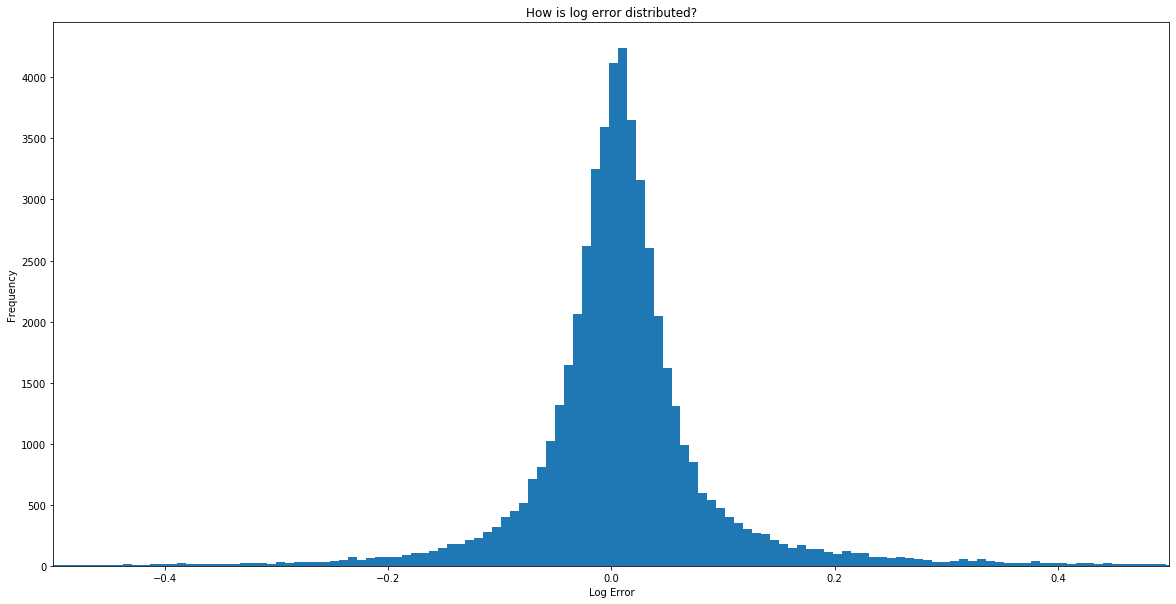

In [7]:
plt.figure(figsize=(20,10))
plt.hist(train.logerror, bins=1000)
plt.xlim(-.5, .5)
plt.xlabel('Log Error')
plt.ylabel('Frequency')
plt.title('How is log error distributed?')
plt.show()

In [8]:
train.logerror.describe()

count    52518.000000
mean         0.016011
std          0.162809
min         -4.655420
25%         -0.023277
50%          0.006617
75%          0.038003
max          3.394544
Name: logerror, dtype: float64

### Q1. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

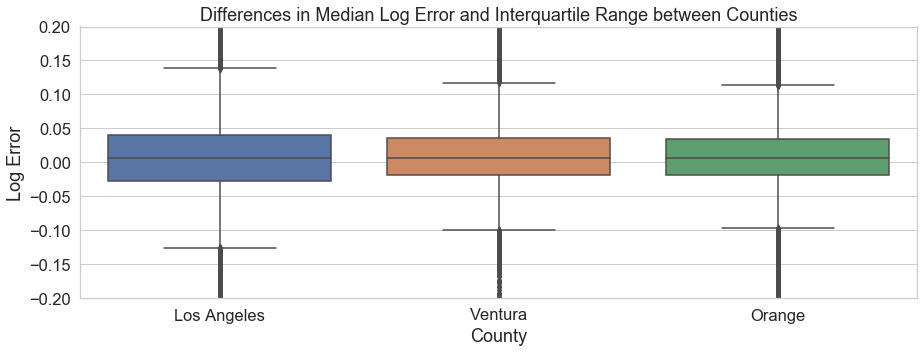

In [9]:
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(15,5))
plt.ylim(-.2, .2) # Range of y-axis is trimmed to better visualize IQR
sns.boxplot(data=train, x=train.fips, y=train.logerror)
plt.title('Differences in Median Log Error and Interquartile Range between Counties')
plt.xlabel('County')
plt.ylabel('Log Error')
plt.show()

In [10]:
train.groupby('fips').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
fips,,,,,,,,
Los Angeles,33916.0,0.013910,0.151394,-4.655420,-0.026780,0.006472,0.039737,3.394544
Orange,14447.0,0.020867,0.187606,-2.406257,-0.018078,0.006907,0.034739,2.933328
Ventura,4155.0,0.016276,0.159583,-2.922919,-0.018415,0.006452,0.036050,2.311174


We can use a one-way Anova to determine if there is a meaningful difference in these means. The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

1. The samples are independent. (Appears to be True)
2. Each sample is from a normally distributed population. (Appears to be True)
3. The standard deviations of the groups are all equal. (Appears to be True)

There might be some minor violation of these assumptions, but if our p-value is low enough, we can be confident in our evaluation. 

$H_0$: There is no difference between the mean log error of these counties.

$H_a$: At least one of these counties has a mean log error that is different from at least one other counties mean log error.

In [11]:
alpha = 0.05
F, p = stats.f_oneway(train.logerror[train.fips == 'Los Angeles'], train.logerror[train.fips == 'Orange'], train.logerror[train.fips == 'Ventura'])
F, p

(9.257558206936508, 9.554371845955292e-05)

In [12]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


Performance of the Kruskal-Wallis test further solidifies our case

$H_0$: There is no difference between the median log error of these counties

$H_a$: At least one of these counties has a median log error that is different from at least one other counties median log error.

In [13]:
alpha = 0.05
H, p = stats.kruskal(train.logerror[train.fips == 'Los Angeles'], train.logerror[train.fips == 'Orange'], train.logerror[train.fips == 'Ventura'])
H, p

(15.284584916994751, 0.0004797274352874927)

In [14]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Takeaways:
There is some difference in Zestimate's ability to predict based on the fips county location data. This location data may be a good candidate for a model feature.

### Q2. Is there a relationship between tax assessed property values and log error?

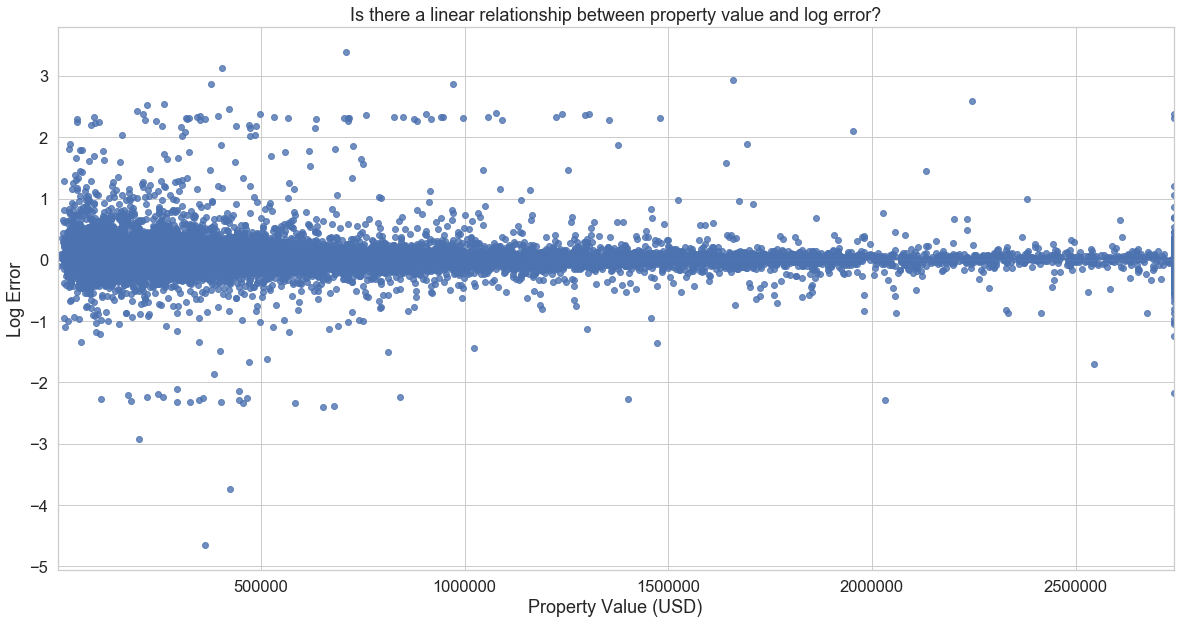

In [15]:
plt.figure(figsize=(20,10))
sns.regplot(data=train, x=train.taxvaluedollarcnt, y= train.logerror)
plt.title('Is there a linear relationship between property value and log error?')
plt.xlabel('Property Value (USD)')
plt.ylabel('Log Error')
plt.show()

Visual inspection of a scatterplot with line of best fit demonstrates that there is no linear relationship between log error and property value, but it appears that the variance of the logerror increases as property value decreases. We can look at this in more detail.

Let's begin by creating a variable absolute_logerror that is the absolute value of the logerror for each observation. Then we can see if there is a linear relationship between absolute logerror and property value.

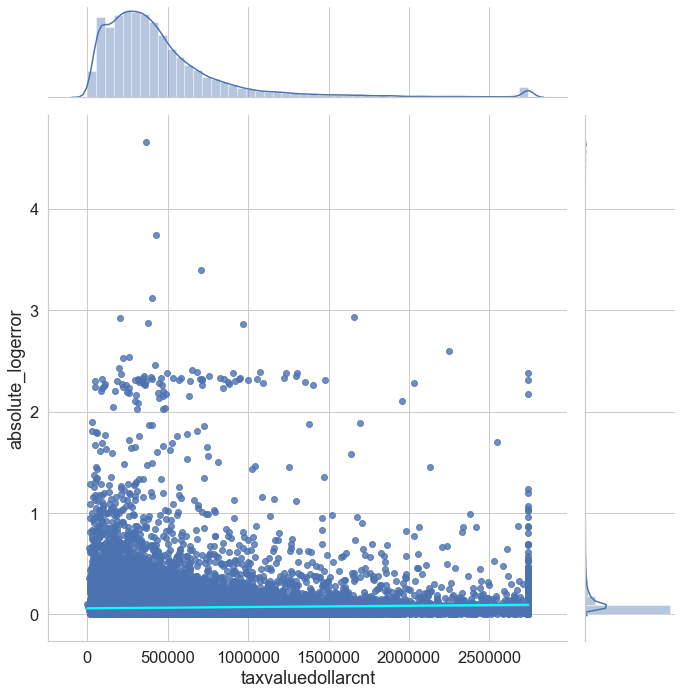

In [16]:
train['absolute_logerror'] = abs(train.logerror) #Creates a new column made only of absolute log error values
g = sns.jointplot(height = 10, x="taxvaluedollarcnt", y="absolute_logerror", data=train, kind='reg',
                  joint_kws={'line_kws':{'color':'cyan'}}) # Colors the regression line cyan for visibility

This doesn't look too promising. The line of best fit is accommodating the compressed upper outliers and appears to be relatively flat overall. Perhaps a better approach will be to bin the data and see if there are meaningful differences between parts of the distribution. 

Text(0, 0.5, 'Log Error')

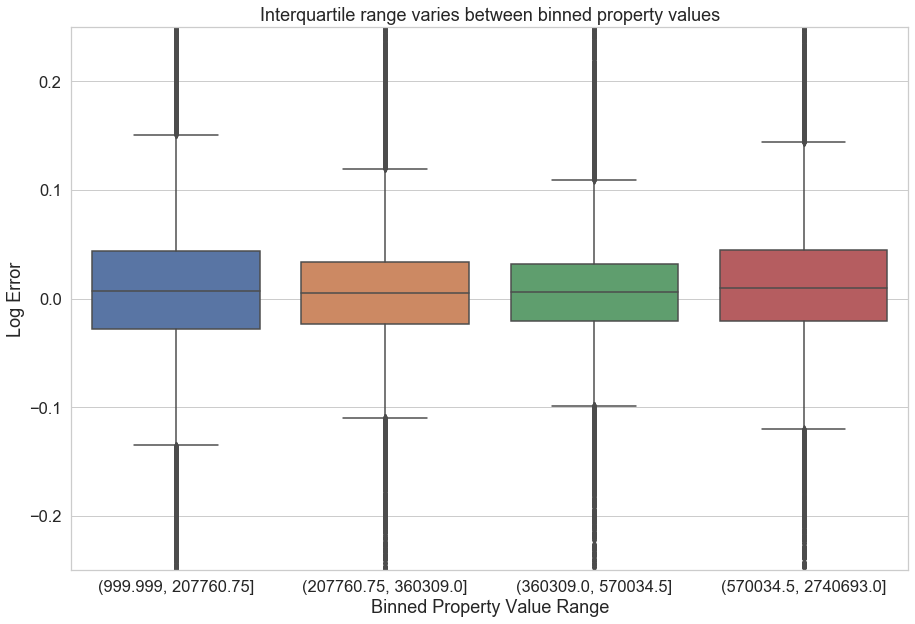

In [17]:
train['binned_value'] = pd.qcut(train['taxvaluedollarcnt'], q=4) #Creates a categorical bin for each quartile
plt.figure(figsize=(15, 10))
plt.ylim(-.25, .25)
sns.boxplot(data=train, x='binned_value', y='logerror')
plt.title('Interquartile range varies between binned property values')
plt.xlabel('Binned Property Value Range')
plt.ylabel('Log Error')

Visual inspection appears to show that there are differences in the interquartile ranges between the binned property value groups.

In [18]:
train.groupby('binned_value').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
binned_value,,,,,,,,
"(999.999, 207760.75]",13130.0,0.021265,0.167731,-2.922919,-0.027911,0.006704,0.043596,2.426789
"(207760.75, 360309.0]",13130.0,0.014490,0.149805,-2.312395,-0.023628,0.004606,0.033694,2.536896
"(360309.0, 570034.5]",13128.0,0.010866,0.146687,-4.655420,-0.020675,0.005679,0.031326,3.123634
"(570034.5, 2740693.0]",13130.0,0.017423,0.184069,-2.406257,-0.021026,0.009958,0.045024,3.394544


There appear to be differences in the means between these groups. We can confirm this with a one-way anova.

$H_0$: There is no difference in the mean log error of these property value quartiles

$H_a$: There is at least one mean log error that differs from on other mean log error within these property value quartiles.

In [19]:
alpha = 0.05
#Compares the mean log error of each binned quartile with the mean log error of the other bins
F, p = stats.f_oneway(train.logerror[train.binned_value.isin((999.999, 207760.75))], 
                      train.logerror[train.binned_value.isin((207760.75, 360309.0))], 
                      train.logerror[train.binned_value.isin((360309.0, 570034.5))],
                      train.logerror[train.binned_value.isin((570034.5, 2740693.0))])
F, p

(10.91553392859798, 3.652443823239081e-07)

In [20]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Takeaways:
- We do not yet know specifically which quartiles are different from each other, but at least one pair of them is different.
- There appears to be a lot of value in binning these property values. The value of categorizing records into bins may be improved through the use of k-means clustering. 

### Q3. Which variables have the highest correlation with logerror?

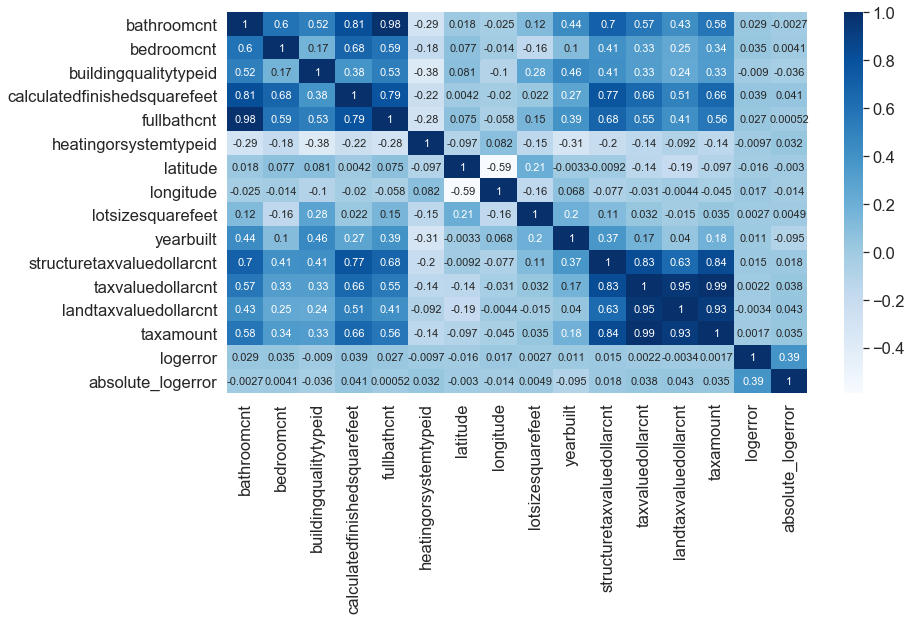

In [21]:
#This function creates a correlation plot of only the numeric data types
explore.corr_plot(train)

There do not appear to be many strong linear correlations between any of the numeric variables and logerror. As we saw earlier however, the lack of a linear correlation does not mean that there is no relationship. We may be able to magnify some of these interactions through clustering techniques. We can review a pairplot to see the interactions between these variables.

### Q4. Are there any relationships between variables that can not be described by the presence or absence of a linear correlation?

There is quite a bit of collinearity between some of the variables used in the correlation plot because they represent the same characteristics (ex: `fullbathcount` and `bathroomcnt`). At this point, its more useful to look at the interactions of features that do not have such a high degree of collinearity. 

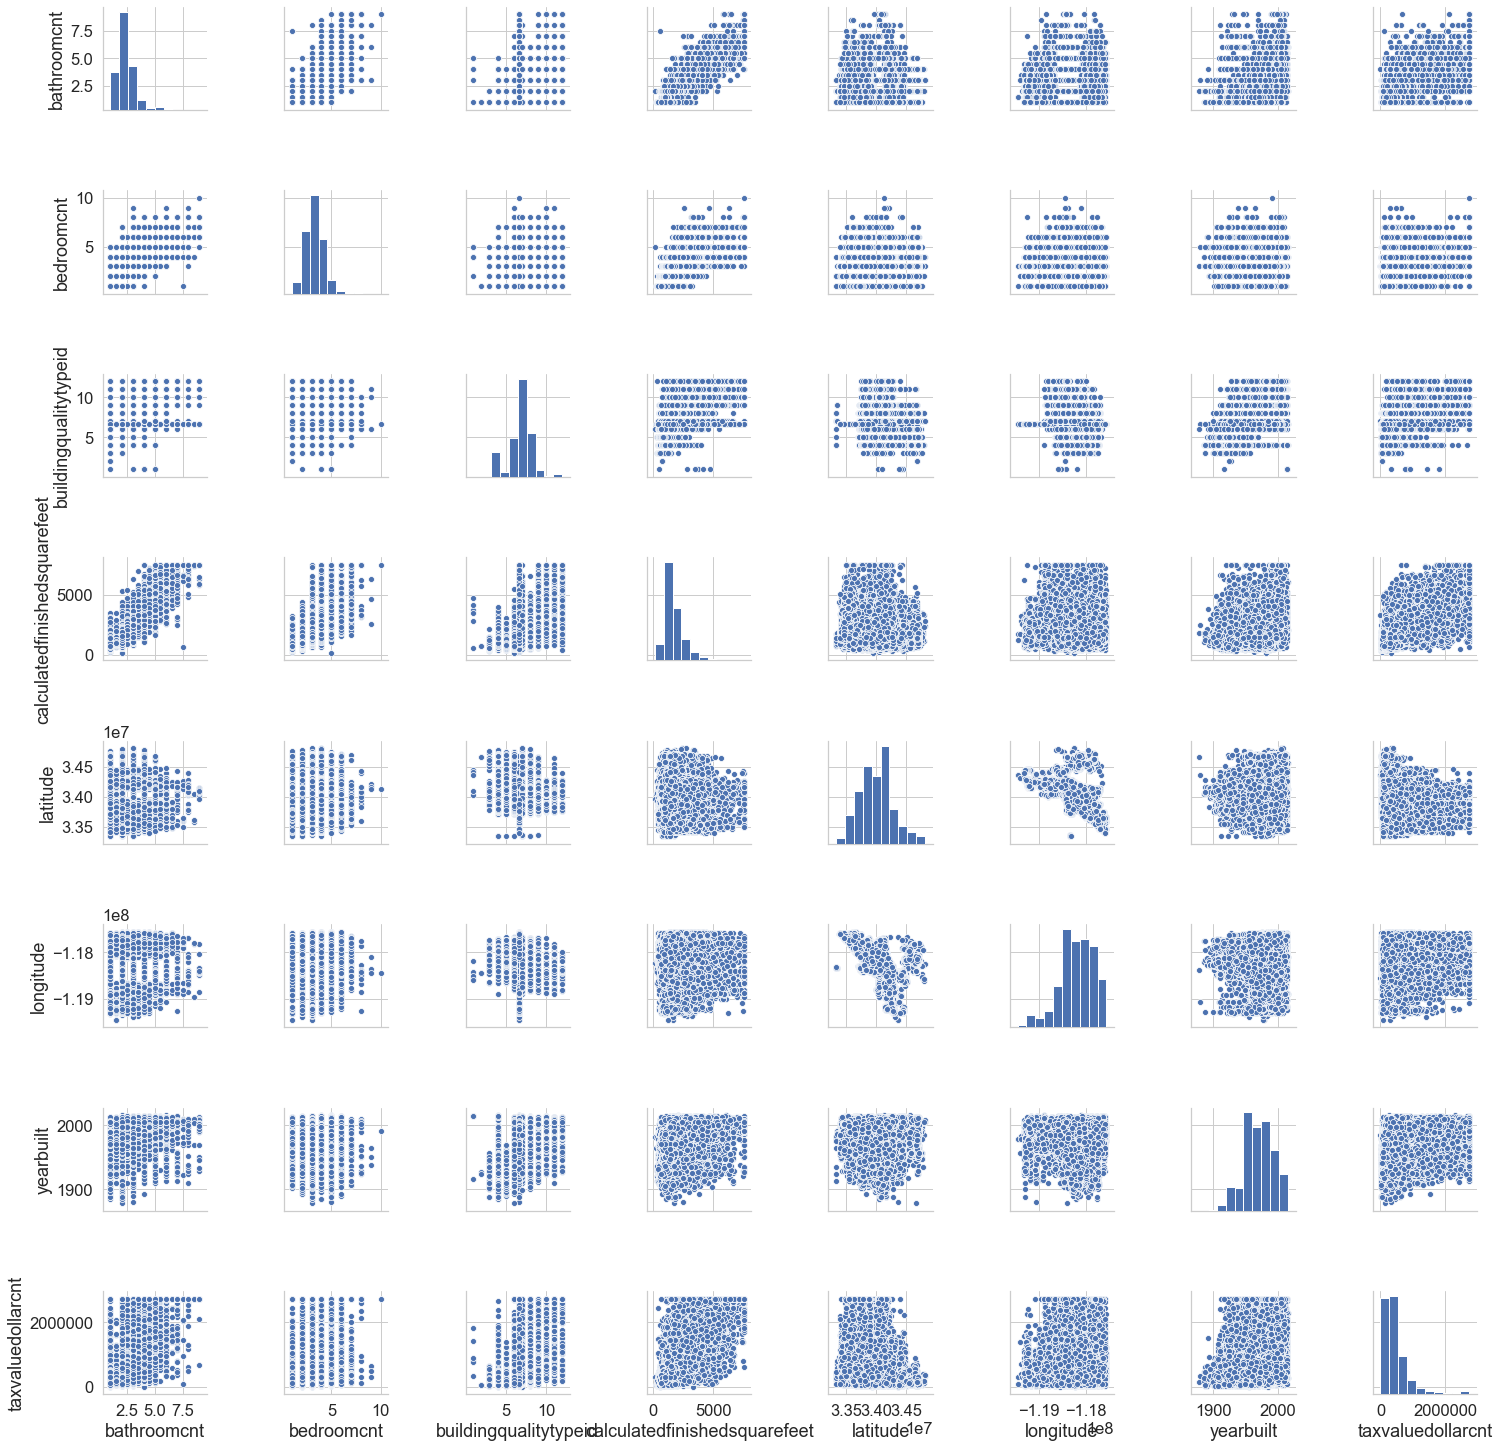

In [22]:
pairs = train[['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'yearbuilt', 'taxvaluedollarcnt']]
sns.pairplot(pairs)

#### Takeaways
- The goal of the pairplot is to identify possible candidates for K-Means Clustering models.
- There are a number of visual relationships that match the general correlation value given in the corrplot above (number of bathrooms and square footage for example appear to take a general positive linear relationship)
- There are other relationships that are not explained through a simple linear correlation.
    - Building quality tends to increase with property value, but there a distinction between low quality homes and higher quality homes. It appears that once you reach at least a quality above 5, the influence on building quality and property value becomes negligible. 
    - Year built and property value area also positively correlated, but it is only the very old homes (1930 and older) that appear to show the most meaningful relationship with property value.
    - Very old homes also appear to have less variance in the number of bedrooms and bathrooms. Older homes tend to have 3 or fewer bathrooms and 5 or fewer bedrooms. Newer homes can have any combination of both across larger ranges. 
    - Buildings of low quality tend to have very few bathrooms. There is a similar pattern in bedrooms but it is not as distinct. 
    - There is some correlation between latitude/longitude and property value, but the relationship between latitude/longitude and other variables are quite weak, suggesting that homes across various latitudes and longitudes tend to not be that different from each other structurally, but are more or less valuable because of neighborhood considerations (like school district quality, crime rates, etc.). 
    
    
- **The relationships that are not as easily explained by simple linear correlation are the ones that may be the most valuable to include in clustering models**

### Q5. Are there clusters of data that have significantly different means of log error?
To begin clustering, we will need to scale the data. We will drop `absolute_logerror` as it was derived from our target variable and so will not be used in any modeling. `binned_value` will also be dropped for the purposes of scaling this data, as categories cannot be scaled. 

In [23]:
train.drop(columns=['absolute_logerror', 'binned_value'], inplace=True)
scaler, train_scaled, validate_scaled, test_scaled = explore.standard_scaler(train, validate, test)

In [24]:
train_scaled.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror
48285,-0.305230,-1.021009,-1.953154,-0.651140,-0.236141,1.232600,-0.490431,-0.572280,-0.761434,-2.337494,-0.876399,-0.402275,-0.102345,-0.467068,0.906449
4918,0.752371,-1.021009,0.266469,0.076185,0.840484,-0.405622,-0.904145,0.072797,0.147291,0.006631,1.071890,0.299497,-0.140073,0.279581,0.204150
14238,0.752371,-0.022975,1.006344,0.211244,0.840484,-0.405622,0.380043,1.243431,-0.686016,0.440728,-0.463018,-0.665836,-0.679111,-0.694309,0.154567
33467,0.752371,0.975058,0.000000,0.085041,0.840484,-0.405622,0.638777,-2.090430,-0.487962,0.180270,-0.138226,-0.462972,-0.566984,-0.579218,0.450750
22026,0.752371,-0.022975,-1.953154,-0.521616,0.840484,-0.405622,-0.767168,0.029597,-0.476781,-2.077036,-0.140767,-0.302806,-0.344812,-0.312034,0.117389


The goal is to identify three different clustering algorithms to see which has the most significant difference in their mean log error. Based on the scaled factors we have available, and the previous evaluation of the pairplot, the K-Means algorithm will be driven by the following sets of factors:

1. `bathroomcnt`, `bedroomcnt`, `calculatedfinishedsquarefeet` - This set is based on the relative importance of these factors individually.  
2. `buildingqualitytypeid`, `taxvaluedollarcnt`, `yearbuilt` - This set is based on the pattern that homes that achieve a certain threshold building quality score tend to have greater variance in the property value. Year built has a relationship with both variables. It will be included to further refine observation distance. 
3. `buildingqualitytypeid`, `bathroomcnt`, `taxvaluedollarcnt` - This set is made of parts of the previous two sets.  

### Cluster Set 1: `bathroomcnt`, `bedroomcnt`, `calculatedfinishedsquarefeet`

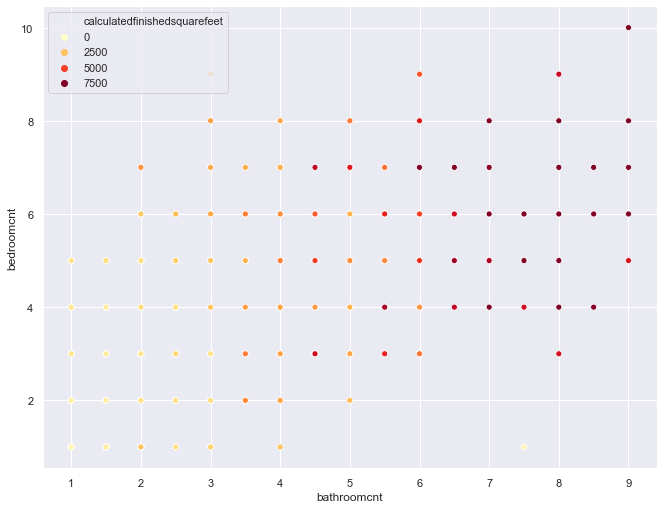

In [25]:
#Visualizing Set #1
sns.set(rc={'figure.figsize':(11,8.5)})
sns.scatterplot(data=train, x='bathroomcnt', y='bedroomcnt', hue='calculatedfinishedsquarefeet', palette='YlOrRd')
plt.show()

As expected, all three factors move in tandem. As any one increases, so do the other two. 

In [26]:
#Creating the dataframe for the first clustering set
X1 = train_scaled[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]

#Creating and fitting the model on the scaled training data
kmeans1 = KMeans(n_clusters=3, random_state=528) #SET
kmeans1.fit(X1)

#Adding the results of the model to the unscaled train dataframe
train['cluster1'] = kmeans1.predict(X1)
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,cluster1
48285,2.0,2.0,4.000000,1170.0,Los Angeles,2.0,7.0,33876919.0,-118405108.0,2258.0,...,38403.0,294146.0,255743.0,3376.55,6.03762e+13,0.163588,2017-06-27,Floor/Wall,Single Family Residential,1
4918,3.0,2.0,7.000000,1827.0,Los Angeles,3.0,2.0,33765300.0,-118172000.0,15018.0,...,360413.0,604073.0,243660.0,7207.01,6.03758e+13,0.049248,2017-01-25,Central,Condominium,0
14238,3.0,3.0,8.000000,1949.0,Los Angeles,3.0,2.0,34111771.0,-117748974.0,3317.0,...,106726.0,177748.0,71022.0,2210.76,6.0374e+13,0.041176,2017-03-07,Central,Planned Unit Development,0
33467,3.0,4.0,6.639845,1835.0,Ventura,3.0,2.0,34181577.0,-118953714.0,6098.0,...,160407.0,267340.0,106933.0,2801.20,6.11101e+13,0.089397,2017-05-11,Central,Condominium,0
22026,3.0,3.0,4.000000,1287.0,Los Angeles,3.0,2.0,33802256.0,-118187611.0,6255.0,...,159987.0,338075.0,178088.0,4171.91,6.03757e+13,0.035123,2017-04-04,Central,Single Family Residential,0


In [27]:
train.cluster1.value_counts()

0    28758
1    17304
2     6456
Name: cluster1, dtype: int64

Although the bulk of the observations are found in cluster 0, there is a large enough proportion in the remaining clusters to suggest that the division is meaningful.

In [28]:
train.groupby('cluster1').mean()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror
cluster1,,,,,,,,,,,,,,,
0,2.404009,3.291710,6.803817,1752.072606,2.331908,2.747444,3.403149e+07,-1.181996e+08,11710.483691,1971.314409,167518.467174,4.345132e+05,266520.833846,5359.943566,0.015196
1,1.495752,2.035368,6.044134,1096.886038,1.448740,4.442499,3.397267e+07,-1.181889e+08,14568.860668,1962.805590,107806.397769,3.102439e+05,202472.827078,3843.409411,0.011331
2,3.899628,4.473358,7.506122,3557.859665,3.783302,2.194703,3.400811e+07,-1.182179e+08,14130.680452,1982.185600,455559.665118,1.070948e+06,617156.493107,12782.419973,0.032187


#### Set 1 Cluster Descriptions:
**Type 0** - The largest group of observations are moderate in nearly every feature. Smaller than Type 2, but larger than Type 1. Built earlier than Type 2, but later than Type 1. They have higher property values than Type 1 homes, but have lower values than Type 2 homes. 

**Type 1** - These are smaller, older homes with lower quality scores and the lower property values to show for it. 

**Type 2** - These are large homes with a high number of bedrooms and bathrooms, which is to be expected of larger homes. They have been built more recently than the other clusters, and are worth quite a bit more. 



In [29]:
train.groupby('cluster1').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
cluster1,,,,,,,,
0,28758.0,0.015196,0.151706,-4.655420,-0.021868,0.006193,0.035201,2.876386
1,17304.0,0.011331,0.164562,-2.922919,-0.028159,0.003955,0.035932,3.123634
2,6456.0,0.032187,0.200527,-2.406257,-0.015580,0.016214,0.057547,3.394544


Looking at log error between the clusters, we see that the larger, more valuable homes have the highest log mean log error overall (almost twice as much as the more common cluster type 0 homes!). 

In [30]:
train.logerror.mean()

0.016011291987422068

Considering the overall mean log error, it appears that logerror is being primarily driven by Type 2 homes. 

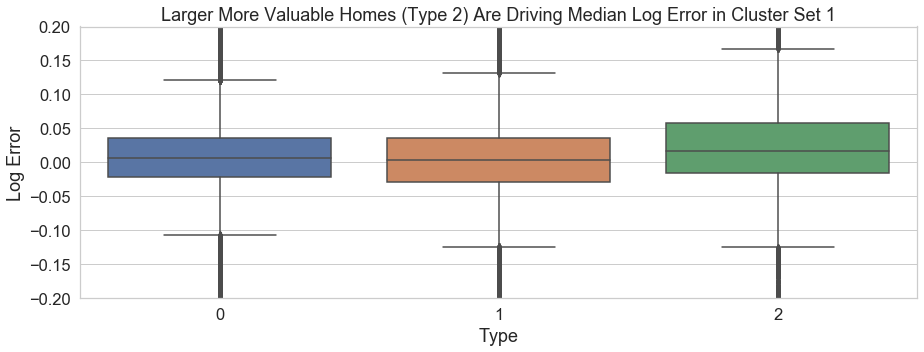

In [31]:
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(15,5))
plt.ylim(-.2, .2) # Range of y-axis is trimmed to better visualize IQR
sns.boxplot(data=train, x=train.cluster1, y=train.logerror)
plt.title('Larger More Valuable Homes (Type 2) Are Driving Median Log Error in Cluster Set 1')
plt.xlabel('Type')
plt.ylabel('Log Error')
plt.show()

From visual inspection, we can see larger differences in median log error compared to our first two categorical comparisons using county and then property value. Type two homes appear to have both a higher median and interquartile range than the other types. 

#### Validation through Statistical Testing
A combination of anova, kruskal-wallis, and t-tests will support the claim that it is 2 type homes that are driving the log error.

#### ANOVA

$H_0$: There is no difference in the mean log errors of the three property types

$H_a$: There is at least one mean log error that is different from one other mean log error within the three property types.

In [32]:
alpha = 0.05
F, p = stats.f_oneway(train.logerror[train.cluster1 == 0], train.logerror[train.cluster1 == 1], train.logerror[train.cluster1 == 2])
F, p

(39.431495825764934, 7.726174384465727e-18)

In [33]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Kruskal-Wallis

$H_0$: There is no difference in the median log errors of the three property types

$H_a$: There is at least one median that is different from one other median within the three property types.

In [34]:
alpha = 0.05
H, p = stats.kruskal(train.logerror[train.cluster1 == 0], train.logerror[train.cluster1 == 1], train.logerror[train.cluster1 == 2])
H, p

(318.78083087281505, 5.992694075344354e-70)

In [35]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


We have identified that there is at least one significant difference present among the three groups.

#### T-Test
Each mean will be compared to each other mean.

- **Type 0 and Type 1**

$H_0$: There is no difference between the mean log error of Type 0 homes and the mean log error of Type 1 homes.

$H_a$: Type 0 homes have a **larger** mean log error than Type 1 homes.

In [36]:
T, p = stats.ttest_ind(train.logerror[train.cluster1 == 0], train.logerror[train.cluster1 == 1])
T, p/2

(2.563968438781637, 0.005175719060112029)

In [37]:
if p/2 < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


- **Type 0 and Type 2**

$H_0$: There is no difference between the mean log error of Type 0 homes and the mean log error of Type 2 homes.

$H_a$: Type 2 have a **larger** mean log error than Type 0

In [38]:
T, p = stats.ttest_ind(train.logerror[train.cluster1 == 2], train.logerror[train.cluster1 == 0])
T, p/2

(7.626949642273872, 1.2320671713338285e-14)

In [39]:
if p/2 < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


- **Type 1 and Type 2**

$H_0$: There is no difference between the mean log error of Type 1 homes and the mean log error of Type 2 homes.

$H_a$: Type 1 homes hava a **smaller** mean log error than Type 2 homes. 

In [40]:
T, p = stats.ttest_ind(train.logerror[train.cluster1 == 1], train.logerror[train.cluster1 == 2])
T, p/2

(-8.16869913049609, 1.6355628755122603e-16)

In [41]:
if p/2 < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Takeways:
- All of the samples have mean log errors that are significantly different from each other. 

        Mean Log Error:
        Type 2 (big, expensive homes) > Type 0 (moderate homes) > Type 1 (small, inexpensive homes)

### Cluster Set 2: `buildingqualitytypeid`, `taxvaluedollarcnt`, `yearbuilt`

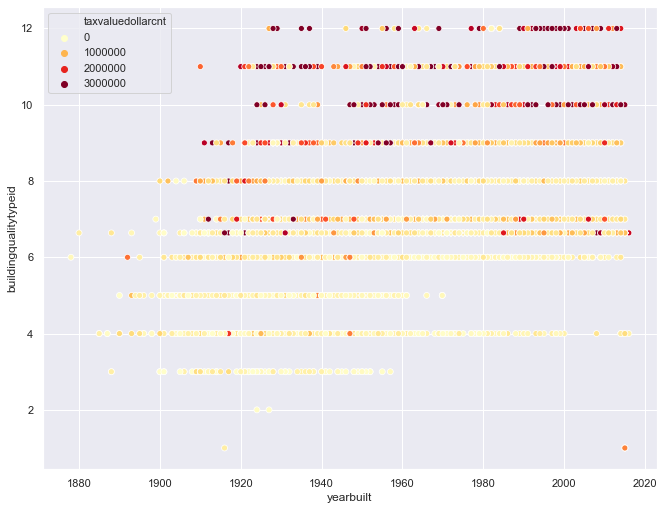

In [42]:
#Visualizing Set #2
sns.set(rc={'figure.figsize':(11,8.5)})
sns.scatterplot(data=train, x='yearbuilt', y='buildingqualitytypeid', hue='taxvaluedollarcnt', palette='YlOrRd')
plt.show()

From visual inspection, it appears that property value is more dependent on the building quality than the year the property was built, but there are virtually no high value properties prior to 1915. At the same time, there are virtually no properties with high building quality prior to 1915, so the relationship may still be driven by building quality more than year built.

In [43]:
#Creating the dataframe for the second clustering set
X2 = train_scaled[['yearbuilt', 'buildingqualitytypeid', 'taxvaluedollarcnt']]

#Creating and fitting the model on the scaled training data
kmeans2 = KMeans(n_clusters=3, random_state=651) #SET
kmeans2.fit(X2)

#Adding the results of the model to the unscaled train dataframe
train['cluster2'] = kmeans2.predict(X2)
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,...,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,cluster1,cluster2
48285,2.0,2.0,4.000000,1170.0,Los Angeles,2.0,7.0,33876919.0,-118405108.0,2258.0,...,294146.0,255743.0,3376.55,6.03762e+13,0.163588,2017-06-27,Floor/Wall,Single Family Residential,1,0
4918,3.0,2.0,7.000000,1827.0,Los Angeles,3.0,2.0,33765300.0,-118172000.0,15018.0,...,604073.0,243660.0,7207.01,6.03758e+13,0.049248,2017-01-25,Central,Condominium,0,1
14238,3.0,3.0,8.000000,1949.0,Los Angeles,3.0,2.0,34111771.0,-117748974.0,3317.0,...,177748.0,71022.0,2210.76,6.0374e+13,0.041176,2017-03-07,Central,Planned Unit Development,0,1
33467,3.0,4.0,6.639845,1835.0,Ventura,3.0,2.0,34181577.0,-118953714.0,6098.0,...,267340.0,106933.0,2801.20,6.11101e+13,0.089397,2017-05-11,Central,Condominium,0,1
22026,3.0,3.0,4.000000,1287.0,Los Angeles,3.0,2.0,33802256.0,-118187611.0,6255.0,...,338075.0,178088.0,4171.91,6.03757e+13,0.035123,2017-04-04,Central,Single Family Residential,0,0


In [44]:
train.cluster2.value_counts()

1    33151
0    15783
2     3584
Name: cluster2, dtype: int64

While not as evenly partitioned as cluster1, there are still enough values in each group to investigate their characteristics. 

In [45]:
train.groupby('cluster2').mean()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,cluster1
cluster2,,,,,,,,,,,,,,,,
0,1.650573,2.843566,5.297775,1344.585947,1.643097,4.807324,3.403384e+07,-1.182149e+08,7735.094469,1944.780792,96521.852785,3.029996e+05,2.066835e+05,3875.037326,0.016181,0.535703
1,2.425115,3.015867,7.119695,1768.223794,2.331483,2.601460,3.400471e+07,-1.181841e+08,15098.435945,1981.067751,180768.910712,4.145174e+05,2.337609e+05,5095.334034,0.015108,0.514193
2,3.835658,3.879464,8.111499,3486.655971,3.719587,2.214844,3.394277e+07,-1.182563e+08,16039.643415,1976.446901,588168.700474,1.745069e+06,1.155431e+06,20395.029066,0.023613,1.315569


#### Set 2 Cluster Descriptions:
**Type 0** - These homes have the fewest bedrooms and bathrooms, the smallest square footage, and are decades older than the other clusters. They also have substantially lower structure values, and moderately land values. A greater proportion of the overall value of the property appears to be coming from the land. 

**Type 1** - This represents the greatest proportion of homes. Mid range in the number of bathrooms, number of bedrooms, and only slightly 20% more square footage than Type 0 homes. Taxes and property values are about 30% higher.  

**Type 2** - Although there are very few of these homes, these are substantially larger and more valuable than the others. The taxes assessed on these property are about 4 times larger than Type 1 homes and 5 times larger than Type 0 homes. Compared to the "large, valuable" homes in Set 1, these homes are "extravagant". 

In [46]:
train.groupby('cluster2').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
cluster2,,,,,,,,
0,15783.0,0.016181,0.169346,-2.271428,-0.032971,0.005033,0.042629,2.523992
1,33151.0,0.015108,0.151578,-4.655420,-0.019549,0.006409,0.033703,3.394544
2,3584.0,0.023613,0.222621,-2.283534,-0.026015,0.019610,0.065045,2.933328


We see in this set of clusters as we saw in the first set. Larger more valuable homes (Type 2) have the greatest mean log error with the greatest standard deviation. However, compared to the first set of clusters, the differences between these three types are not as pronounced. 

In [47]:
train.logerror.mean()

0.016011291987422068

Based on this cluster, its not quite as strong of a case for asserting that larger more valuable homes (at least as defined by Set 2 Type 2) are driving the log error, but the mean is still being driven higher by them compared to the other types. 

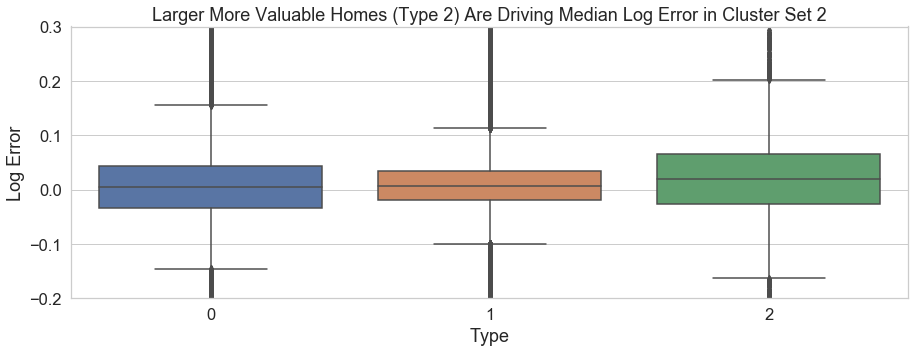

In [48]:
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(15,5))
plt.ylim(-.2, .3) # Range of y-axis is trimmed to better visualize IQR
sns.boxplot(data=train, x=train.cluster2, y=train.logerror)
plt.title('Larger More Valuable Homes (Type 2) Are Driving Median Log Error in Cluster Set 2')
plt.xlabel('Type')
plt.ylabel('Log Error')
plt.show()

From visual inspection, we again see that larger homes have higher median log error. Within this set, Type 1 homes (moderately sized and valued) a much smaller interquartile range than the others. 

#### Validation through Statistical Testing
A combination of anova, kruskal-wallis, and t-tests will support the claim that it is 2 type homes that are driving the log error.

#### ANOVA

$H_0$: There is no difference in the mean log errors of the three property types

$H_a$: There is at least one mean log error that is different from one other mean log error within the three property types.

In [49]:
alpha = 0.05
F, p = stats.f_oneway(train.logerror[train.cluster2 == 0], train.logerror[train.cluster2 == 1], train.logerror[train.cluster2 == 2])
F, p

(4.425972469309437, 0.011967035037568125)

In [50]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Kruskal-Wallis

$H_0$: There is no difference in the median log errors of the three property types

$H_a$: There is at least one median that is different from one other median within the three property types.

In [51]:
alpha = 0.05
H, p = stats.kruskal(train.logerror[train.cluster2 == 0], train.logerror[train.cluster2 == 1], train.logerror[train.cluster2 == 2])
H, p

(126.21737972890026, 3.910607525851808e-28)

In [52]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


We have identified that there is at least one significant difference present among the three groups.

#### T-Test
Each mean will be compared to each other mean.

- **Type 0 and Type 1**

$H_0$: There is no difference between the mean log error of Type 0 homes and the mean log error of Type 1 homes.

$H_a$: Type 0 homes have a **larger** mean log error than Type 1 homes.

In [53]:
T, p = stats.ttest_ind(train.logerror[train.cluster2 == 0], train.logerror[train.cluster2 == 1])
T, p/2

(0.7043464733468578, 0.240610191669812)

In [54]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We fail to reject the null hypothesis


- **Type 0 and Type 2**

$H_0$: There is no difference between the mean log error of Type 0 homes and the mean log error of Type 2 homes.

$H_a$: Type 2 have a **larger** mean log error than Type 0 homes.

In [55]:
T, p = stats.ttest_ind(train.logerror[train.cluster2 == 2], train.logerror[train.cluster2 == 0])
T, p/2

(2.226530445004999, 0.012995064681050984)

In [56]:
if p/2 < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


- **Type 1 and Type 2**

$H_0$: There is no difference between the mean log error of Type 1 homes and the mean log error of Type 2 homes.

$H_a$: Type 2 homes hava a **larger** mean log error than Type 1 homes.

In [57]:
T, p = stats.ttest_ind(train.logerror[train.cluster2 == 2], train.logerror[train.cluster2 == 1])
T, p/2

(3.0248777105107023, 0.0012445277321221438)

In [58]:
if p/2 < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Takeways:
- Type 2 is larger than both Type 1 and Type 0, but Type 1 and Type 0 are equal to each other. 

        Mean Log Error:
        Type 2 (extravagant homes) > Type 1 (moderate homes) = Type 0 (small, inexpensive homes)
        
- The p-values are larger for similar tests in this set than were found in set 1. Furthermore, the differences between the groups are smaller. 
- Currently, cluster set 1 shows more promise for being a feature in a model than cluster set 2.

### Cluster Set 3: `buildingqualitytypeid`, `bathroomcnt`, `taxvaluedollarcnt`

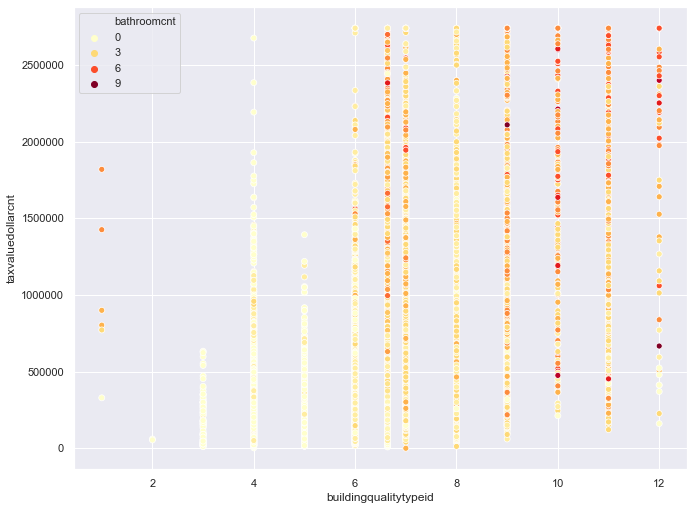

In [59]:
#Visualizing Set #3
sns.set(rc={'figure.figsize':(11,8.5)})
sns.scatterplot(data=train, x='buildingqualitytypeid', y='taxvaluedollarcnt', hue='bathroomcnt', palette='YlOrRd')
plt.show()

From visual inspection, it appears that a building quality rating of 6 is the threshold that must be crossed before higher property values are given to a home. The same holds true for bathrooms, as homes with only 1 or 2 bathrooms tend to get neither high quality scores nor high property values. 

In [60]:
#Creating the dataframe for the third clustering set
X3 = train_scaled[['bathroomcnt', 'buildingqualitytypeid', 'taxvaluedollarcnt']]

#Creating and fitting the model on the scaled training data
kmeans3 = KMeans(n_clusters=3, random_state=379) #SET
kmeans3.fit(X3)

#Adding the results of the model to the unscaled train dataframe
train['cluster3'] = kmeans3.predict(X3)
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,...,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,cluster1,cluster2,cluster3
48285,2.0,2.0,4.000000,1170.0,Los Angeles,2.0,7.0,33876919.0,-118405108.0,2258.0,...,255743.0,3376.55,6.03762e+13,0.163588,2017-06-27,Floor/Wall,Single Family Residential,1,0,0
4918,3.0,2.0,7.000000,1827.0,Los Angeles,3.0,2.0,33765300.0,-118172000.0,15018.0,...,243660.0,7207.01,6.03758e+13,0.049248,2017-01-25,Central,Condominium,0,1,2
14238,3.0,3.0,8.000000,1949.0,Los Angeles,3.0,2.0,34111771.0,-117748974.0,3317.0,...,71022.0,2210.76,6.0374e+13,0.041176,2017-03-07,Central,Planned Unit Development,0,1,2
33467,3.0,4.0,6.639845,1835.0,Ventura,3.0,2.0,34181577.0,-118953714.0,6098.0,...,106933.0,2801.20,6.11101e+13,0.089397,2017-05-11,Central,Condominium,0,1,2
22026,3.0,3.0,4.000000,1287.0,Los Angeles,3.0,2.0,33802256.0,-118187611.0,6255.0,...,178088.0,4171.91,6.03757e+13,0.035123,2017-04-04,Central,Single Family Residential,0,0,0


In [61]:
train.cluster3.value_counts()

2    30897
0    17685
1     3936
Name: cluster3, dtype: int64

The proportions of this cluster set are similar to the proportions of cluster set 2. 

In [62]:
train.groupby('cluster3').mean()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,cluster1,cluster2
cluster3,,,,,,,,,,,,,,,,,
0,1.498191,2.588126,5.367037,1197.575968,1.471303,4.697484,3.404243e+07,-1.181979e+08,10327.976195,1953.456824,91833.585242,2.680810e+05,1.764099e+05,3450.953355,0.015613,0.615154,0.255018
1,4.147866,4.110518,8.009037,3671.127287,4.010925,2.185976,3.395023e+07,-1.182462e+08,16002.791159,1979.884792,592191.807800,1.641771e+06,1.048299e+06,19257.652774,0.024340,1.539126,1.787348
2,2.504175,3.133411,7.193960,1835.371525,2.419264,2.536622,3.399775e+07,-1.181924e+08,14061.562061,1977.950205,183484.716105,4.393699e+05,2.559033e+05,5383.781126,0.015178,0.429783,0.931288


#### Set 3 Cluster Descriptions:

**Type 0** - Smaller, older, less valuable homes. 

**Type 1** - Similar to the last cluster set, there is a grouping of homes that are substantially larger and more valuable than the others that make up the smallest proportion of the sample. 

**Type 2** - Mid range homes in both size and value. These make up the greatest proportion of the sample. 

In [63]:
train.groupby('cluster3').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
cluster3,,,,,,,,
0,17685.0,0.015613,0.169241,-4.655420,-0.029887,0.004345,0.038728,3.123634
1,3936.0,0.024340,0.209408,-2.283534,-0.022675,0.018452,0.063576,2.933328
2,30897.0,0.015178,0.151880,-3.737018,-0.019852,0.006738,0.034747,3.394544


The means of these groups already look similar to what we found in set 2. It is likely that the mean log error of the "big, expensive" homes will be larger than both of the other groups, but the small and mid range homes will have similar means. 

In [64]:
train.logerror.mean()

0.016011291987422068

In this set, there is only one group that has a sample mean larger than the overall mean. This means that there is a very strong case that the log error is being driven by weaker predictions on larger more expensive homes. 

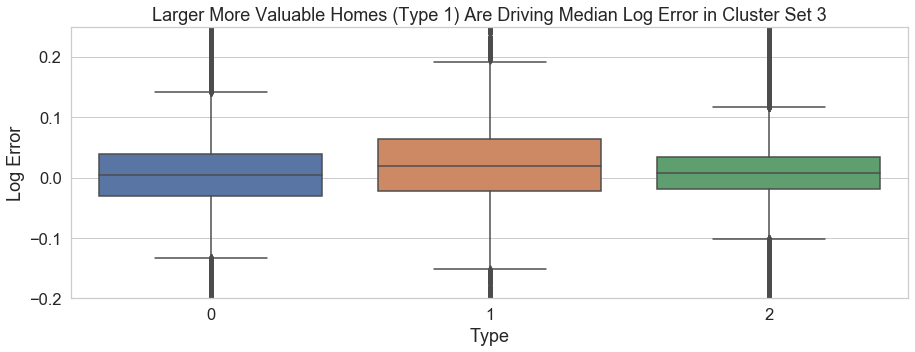

In [65]:
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(15,5))
plt.ylim(-.2, .25) # Range of y-axis is trimmed to better visualize IQR
sns.boxplot(data=train, x=train.cluster3, y=train.logerror)
plt.title('Larger More Valuable Homes (Type 1) Are Driving Median Log Error in Cluster Set 3')
plt.xlabel('Type')
plt.ylabel('Log Error')
plt.show()

From visual inspection, we again see that larger homes have higher median log error. Within this set, Type 2 homes (moderately sized and valued) a much smaller interquartile range than the others. This is very similar to what was seen in set 2.

#### Validation through Statistical Testing
A combination of anova, kruskal-wallis, and t-tests will support the claim that it is 1 type homes that are driving the log error.

#### ANOVA

$H_0$: There is no difference in the mean log errors of the three property types

$H_a$: There is at least one mean log error that is different from one other mean log error within the three property types.

In [66]:
alpha = 0.05
F, p = stats.f_oneway(train.logerror[train.cluster3 == 0], train.logerror[train.cluster3 == 1], train.logerror[train.cluster3 == 2])
F, p

(5.608220137772659, 0.003669788287583019)

In [67]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Kruskal-Wallis

$H_0$: There is no difference in the median log errors of the three property types

$H_a$: There is at least one median that is different from one other median within the three property types.

In [68]:
alpha = 0.05
H, p = stats.kruskal(train.logerror[train.cluster3 == 0], train.logerror[train.cluster3 == 1], train.logerror[train.cluster3 == 2])
H, p

(165.35621752220547, 1.2398055920030863e-36)

In [69]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


We have identified that there is at least one significant difference present among the three groups.

#### T-Test
Each mean will be compared to each other mean.

- **Type 0 and Type 1**

$H_0$: There is no difference between the mean log error of Type 0 homes and the mean log error of Type 1 homes.

$H_a$: Type 1 homes have a **larger** mean log error than Type 0 homes.

In [70]:
T, p = stats.ttest_ind(train.logerror[train.cluster3 == 1], train.logerror[train.cluster3 == 0])
T, p/2

(2.7936937522106757, 0.0026077821605984667)

In [71]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


- **Type 0 and Type 2**

$H_0$: There is no difference between the mean log error of Type 0 homes and the mean log error of Type 2 homes.

$H_a$: There is a difference between the mean log error of Type 0 homes and the mean log error of Type 2 homes.

In [72]:
T, p = stats.ttest_ind(train.logerror[train.cluster3 == 0], train.logerror[train.cluster3 == 2])
T, p

(0.29148739769051984, 0.7706798253574089)

In [73]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We fail to reject the null hypothesis


- **Type 1 and Type 2**

$H_0$: There is no difference between the mean log error of Type 1 homes and the mean log error of Type 2 homes.

$H_a$: Type 1 homes hava a **larger** mean log error than Type 2 homes.

In [74]:
T, p = stats.ttest_ind(train.logerror[train.cluster3 == 1], train.logerror[train.cluster3 == 2])
T, p

(3.3955785314787317, 0.0006856014861642604)

In [75]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Takeways:
- Type 1 is larger than both Type 2 and Type 0, but Type 2 and Type 0 are equal to each other. 

        Mean Log Error:
        Type 1 (extravagant homes) > Type 2 (moderate homes) = Type 0 (small, inexpensive homes)
        
- Like set 2, the p-values are larger for similar tests in this set than were found in set 1. Furthermore, the differences between the groups are smaller. 
- Currently, cluster set 1 shows more promise for being a feature in a model than either cluster set 2 or cluster set 3

### Cluster Set 4: `latitude`, `longitude`

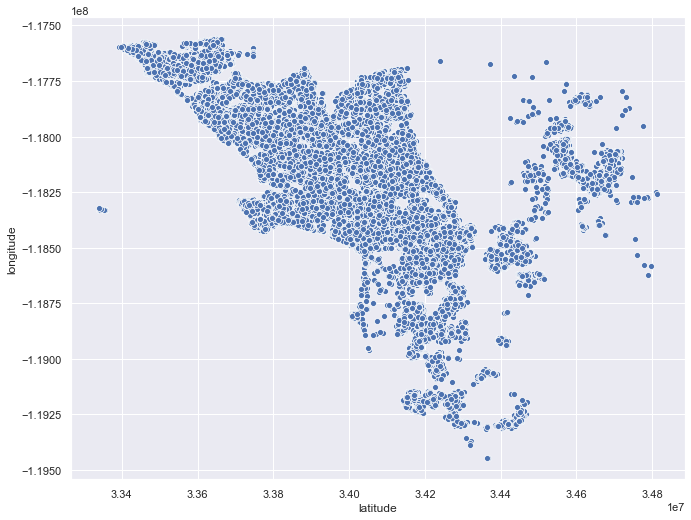

In [76]:
#Visualizing Set #4
sns.set(rc={'figure.figsize':(11,8.5)})
sns.scatterplot(data=train, x='latitude', y='longitude')
plt.show()

Unlike the other visualizations at this stage, our two variables here are both assumed to be independent of each other. This is instead more of a geographical map of the property locations, and certain clusters may exhibit similar qualities, due to the importance of location in establishing home value and the way that entire neighborhoods may be built in a similar fashion. 

In [77]:
#Creating the dataframe for the fourth clustering set
X4 = train_scaled[['latitude', 'longitude']]

#Creating and fitting the model on the scaled training data
kmeans4 = KMeans(n_clusters=5, random_state=379) 
kmeans4.fit(X4)

#Adding the results of the model to the unscaled train dataframe
train['region'] = kmeans4.predict(X4)
train_scaled['region'] = kmeans4.predict(X4)
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,...,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,cluster1,cluster2,cluster3,region
48285,2.0,2.0,4.000000,1170.0,Los Angeles,2.0,7.0,33876919.0,-118405108.0,2258.0,...,3376.55,6.03762e+13,0.163588,2017-06-27,Floor/Wall,Single Family Residential,1,0,0,2
4918,3.0,2.0,7.000000,1827.0,Los Angeles,3.0,2.0,33765300.0,-118172000.0,15018.0,...,7207.01,6.03758e+13,0.049248,2017-01-25,Central,Condominium,0,1,2,4
14238,3.0,3.0,8.000000,1949.0,Los Angeles,3.0,2.0,34111771.0,-117748974.0,3317.0,...,2210.76,6.0374e+13,0.041176,2017-03-07,Central,Planned Unit Development,0,1,2,4
33467,3.0,4.0,6.639845,1835.0,Ventura,3.0,2.0,34181577.0,-118953714.0,6098.0,...,2801.20,6.11101e+13,0.089397,2017-05-11,Central,Condominium,0,1,2,3
22026,3.0,3.0,4.000000,1287.0,Los Angeles,3.0,2.0,33802256.0,-118187611.0,6255.0,...,4171.91,6.03757e+13,0.035123,2017-04-04,Central,Single Family Residential,0,0,0,4


In [78]:
train.region.value_counts()

4    18246
2    14529
1    10578
0     4671
3     4494
Name: region, dtype: int64

The distribution of clusters looks well proportioned. There are 5 clusters instead of the 3 that we have been operating with thus far because of the need to differentiate geographical regions more finely. 

In [79]:
train.groupby('region').mean()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,cluster1,cluster2,cluster3
region,,,,,,,,,,,,,,,,,,
0,2.458788,3.325626,7.006602,1846.252194,2.458788,2.502890,3.454451e+07,-1.182936e+08,18718.125134,1987.020306,179115.126097,279377.978591,100163.864697,4336.564538,0.013795,0.462428,0.868979,1.335902
1,2.433069,3.044337,6.640140,1911.421346,2.222065,3.252505,3.365273e+07,-1.177744e+08,7187.303413,1981.325298,200598.189403,570804.436661,369042.558045,6565.651075,0.021144,0.643789,1.023918,1.634714
2,2.326175,2.840457,6.930352,1781.819120,2.325762,3.308693,3.413225e+07,-1.184005e+08,17106.662055,1961.031777,210678.305320,579175.493771,368992.643420,7042.020193,0.007493,0.657788,0.735839,1.139101
3,2.419003,3.303516,6.736751,1955.528927,2.255229,2.016689,3.423222e+07,-1.189728e+08,10701.244993,1979.192071,221853.489653,490019.344682,268975.565254,5727.819489,0.017007,0.552737,0.967067,1.672897
4,2.099255,3.009482,6.290590,1579.365669,2.062863,3.662282,3.392602e+07,-1.180679e+08,12057.633564,1963.514591,142910.342102,373687.588074,230795.262606,4680.973071,0.020141,0.504494,0.569549,0.993642


#### Set 4 Cluster Descriptions:

These types are a little more difficult to distinguish from each other, in part because there are more of them, but also because some of variables have little variation from one region to the next. There are however, several distinctive differences:

**Size** - Both for square footage and lot size, these regions show variety. Region 4 is characterized by much smaller homes than Region 1. 

**Year Built** - Some regions are considerably older than others. Region 4 and 2 both have a mean year built in the early 1960s, while the other regions were built closer to 1980 or later. 

**Property Value** - Region 0 has considerably lower property values than regions 1, 2, and 3. 

#### Cluster Region Visualization

While these individual regions are more difficult to distinguish from each other via their summary statistics, it is clear from a visual inspection that they represent distinct geographical regions.

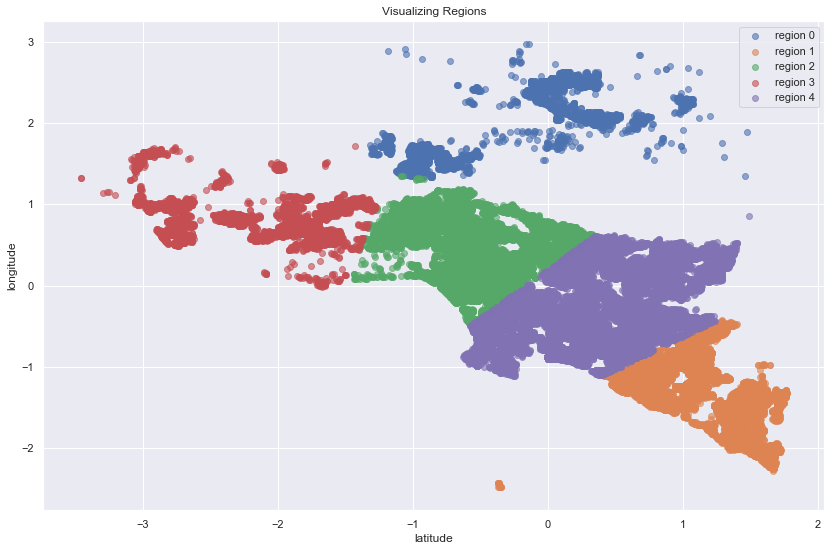

In [80]:
explore.visualize_regions(kmeans4, X4, train_scaled, 'region')

In [81]:
train.groupby('region').logerror.describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
0,4671.0,0.013795,0.129030,-0.924699,-0.020884,0.004376,0.030042,2.523992
1,10578.0,0.021144,0.191256,-2.406257,-0.018065,0.006784,0.035236,3.123634
2,14529.0,0.007493,0.158805,-3.737018,-0.034170,0.006082,0.043392,2.876386
3,4494.0,0.017007,0.157745,-2.922919,-0.018387,0.007073,0.037869,2.311174
4,18246.0,0.020141,0.156622,-4.655420,-0.021379,0.007247,0.037779,3.394544


In [82]:
train.logerror.mean()

0.016011291987422068

There appear to be meaningful differences between the mean log error of each region. Region 2, for example, has a log error much lower than the overall mean of log error. Region 1 and 4 have higher mean log error than the overall mean. 

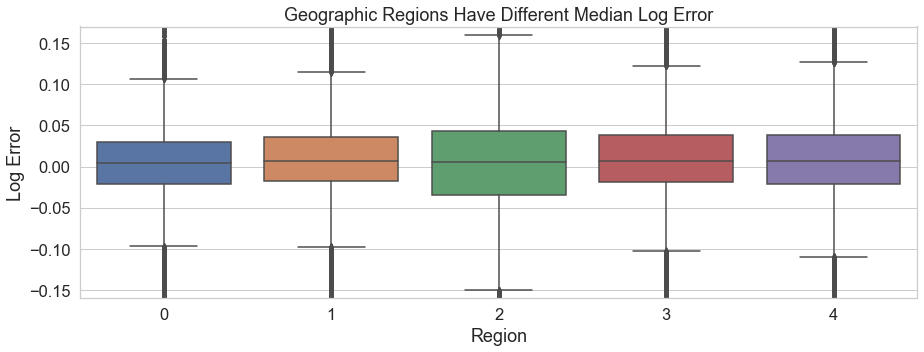

In [83]:
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(15,5))
plt.ylim(-.16, .17) # Range of y-axis is trimmed to better visualize IQR
sns.boxplot(data=train, x=train.region, y=train.logerror)
plt.title('Geographic Regions Have Different Median Log Error')
plt.xlabel('Region')
plt.ylabel('Log Error')
plt.show()

#### Validation through Statistical Testing
A combination of anova and kruskal-wallis will support the claim that these regions vary enough in log error mean and median to use in future modeling efforts. 

#### ANOVA

$H_0$: There is no difference in the mean log errors of the five regions.

$H_a$: There is at least one mean log error that is different from one other mean log error within the five regions.

In [84]:
alpha = 0.05
F, p = stats.f_oneway(train.logerror[train.region == 0], train.logerror[train.region == 1], train.logerror[train.region == 2], train.logerror[train.region == 3], train.logerror[train.region == 4])
F, p

(15.782711718599582, 6.483289417205505e-13)

In [85]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### Kruskal-Wallis

$H_0$: There is no difference in the median log errors of the five regions.

$H_a$: There is at least one median that is different from one other median within the five regions.

In [86]:
alpha = 0.05
H, p = stats.kruskal(train.logerror[train.region == 0], train.logerror[train.region == 1], train.logerror[train.region == 2], train.logerror[train.region == 3], train.logerror[train.region == 4])
H, p

(54.42109804658612, 4.2955645334121345e-11)

In [87]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


We have identified that there is at least one significant difference present among the five regions.

### Exploration Summary
- There are significant differences in log error between county (fips code), binned property value quartiles, and clusters that separate the data into three groups:
    - Cluster Set: `bathroomcnt`, `bedroomcnt`, `calculatedfinishedsquarefeet`
        - Type 0: Moderately sized and valued homes built around 1971
        - Type 1: Smaller sized lower value homes of lower quality built around 1963
        - Type 2: Larger sized and higher valued homes built around 1982
- There is also some potential value in clustering on `latitude` and `longitude` and these clusters will also be passed forward to the next stage.
- One hot encoding will be used to add the set 1 cluster categories to our model. 
- A correlation plot identified some small linear correlations between most of the variables and logerror. Identifying which of these will be most valuable is difficult due to how small the correlations are. 
- SelectKMeans and RFE will be used to develop the most valuable features. 

# Feature Selection


Before we can begin modeling, object type data that will be included in our model will need to be encoded. Our validate and test sets are still missing the cluster1 column, so we will begin by using our KMeans1 model on those datasets. 

In [88]:
X1v = validate_scaled[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
validate['cluster1'] = kmeans1.predict(X1v)
X4v = validate_scaled[['latitude', 'longitude']]
validate['region'] = kmeans4.predict(X4v)

In [89]:
X1t = test_scaled[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet']]
test['cluster1'] = kmeans1.predict(X1t)
X4t = test_scaled[['latitude', 'longitude']]
test['region'] = kmeans4.predict(X4t)

Now the categorical variables that we intend to use will need to be encoded. `fips` and `cluster1` will be passed into the explore.one_hot_encoding() function. 

In [90]:
train = explore.one_hot_encoding(train, ['fips', 'cluster1', 'region'])
validate = explore.one_hot_encoding(validate, ['fips', 'cluster1', 'region'])
test = explore.one_hot_encoding(test, ['fips', 'cluster1', 'region'])

Now that our categorical variables are encoded, we will drop all other object type variables from the dataframes. 

In [91]:
train, validate, test = explore.drop_object_variables(train, validate, test)

To pass our features through a SelectKBest algorithm or RFE, the target variable will need to be separated from the dataframe and the independent variables will need to be scaled. 

In [92]:
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fullbathcnt,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,...,taxamount,logerror,fips_Orange,fips_Ventura,cluster1_1,cluster1_2,region_1,region_2,region_3,region_4
48285,2.0,2.0,4.000000,1170.0,2.0,33876919.0,-118405108.0,2258.0,1916.0,38403.0,...,3376.55,0.163588,0,0,1,0,0,1,0,0
4918,3.0,2.0,7.000000,1827.0,3.0,33765300.0,-118172000.0,15018.0,1970.0,360413.0,...,7207.01,0.049248,0,0,0,0,0,0,0,1
14238,3.0,3.0,8.000000,1949.0,3.0,34111771.0,-117748974.0,3317.0,1980.0,106726.0,...,2210.76,0.041176,0,0,0,0,0,0,0,1
33467,3.0,4.0,6.639845,1835.0,3.0,34181577.0,-118953714.0,6098.0,1974.0,160407.0,...,2801.20,0.089397,0,1,0,0,0,0,1,0
22026,3.0,3.0,4.000000,1287.0,3.0,33802256.0,-118187611.0,6255.0,1922.0,159987.0,...,4171.91,0.035123,0,0,0,0,0,0,0,1


In [93]:
X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test = explore.create_scaled_x_y(train, validate, test, target='logerror')

### SelectKBest

In [94]:
skb_features = explore.select_kbest(X_train_scaled, y_train, 6)
skb_features

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'cluster1_2',
 'region_2']

### Recursive Feature Elimination

In [95]:
rfe_features = explore.rfe(X_train_scaled, y_train, 6)
rfe_features

['calculatedfinishedsquarefeet',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'region_1',
 'region_4']

While SelectKBest made use of our home characteristic clustering and our region clustering, RFE only made use of our region clustering and focused heavily on tax assessment characteristics. There is some concern that RFE is at risk for multicollinearity due to the overreliance on tax related variables. 

# Modeling
We can create models using the features from both SelectKBest and RFE and determine which algorithm produces better results. We will begin by setting up a baseline.

In [96]:
# Compute baseline prediction using mean
mean = y_train.agg(['mean'])
baseline = np.array([mean]*y_train.size)

In [97]:
baseline_rmse = explore.baseline_rmse(y_train)
print(f'Baseline root mean squared error: {baseline_rmse}')

Baseline root mean squared error: 0.1628075453595771


## Comparing 5 Different Models
1. LinearRegression , Features = skb_features
2. LinearRegression , Features = rfe_features
3. LinearRegression + Polynomial Features (3rd Degree), Features = skb_features
4. LinearRegression (fit_intercept=False) + Polynomial Features (3rd Degree), Features = skb_features
5. LinearRegression + Polynomial Features (3rd Degree), Features = rfe_features

### MODEL 1: Linear Regression , Features = skb_features

In [98]:
# Creating X_train_scaled with skb_features selected
X_train_scaled_skb = X_train_scaled[skb_features]

In [99]:
# Create lm object

lm1 = LinearRegression()
lm1

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [100]:
# Find root mean squared error for linear regression model with SelectKBest features
lm_skb1 = lm1.fit(X_train_scaled_skb, y_train)
lm_pred_skb1 = lm_skb1.predict(X_train_scaled_skb)
lm_rmse_skb1 = math.sqrt(mean_squared_error(y_train, lm_pred_skb1))

print('Model 1: Linear Regression with SelectKBest Features')
print(f'Root Mean Squared Error: {lm_rmse_skb1}')

Model 1: Linear Regression with SelectKBest Features
Root Mean Squared Error: 0.16257813176955066


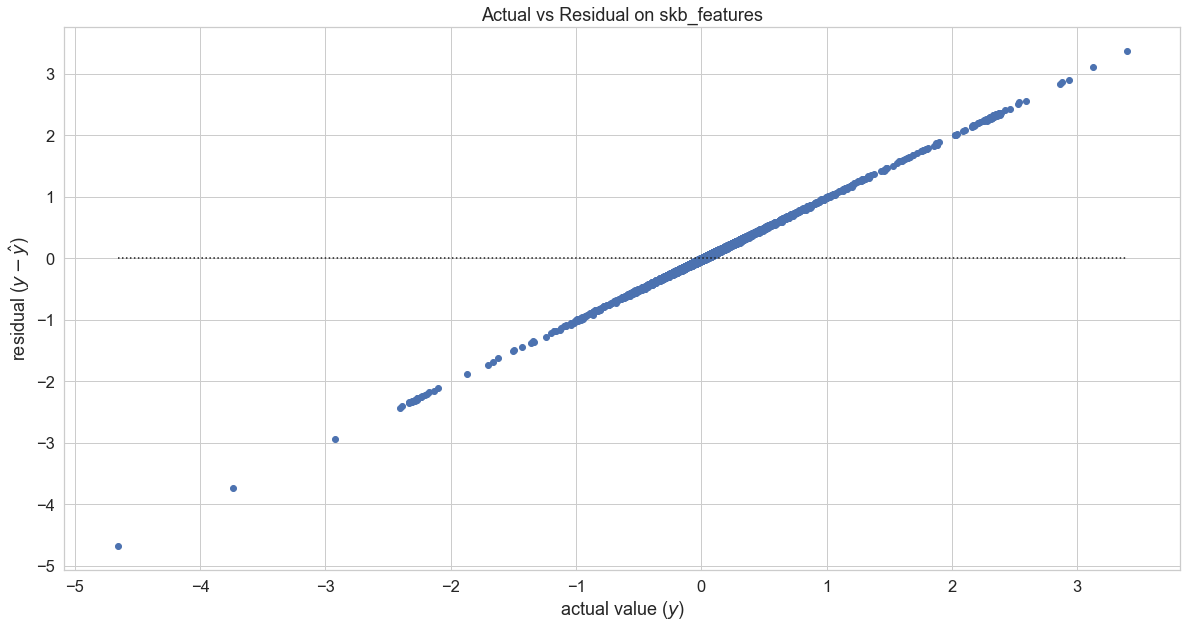

In [101]:
# Residual plot
explore.plot_residuals(y_train, lm_pred_skb1, 'skb_features')

#### Takeaway
- This model is only marginally outperforming the baseline model on the train data set. 
- When log error is positive, our model is predicting it to be quite a bit higher than it actually is.
- When log error is negative, our model is predicting it to be even more negative than it actually is.

### MODEL 2: LinearRegression , Features = rfe_features

In [102]:
# Creating X_train_scaled with rfe_features selected
X_train_scaled_rfe = X_train_scaled[rfe_features]

In [103]:
# Create lm object

lm2 = LinearRegression()
lm2

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [104]:
# Find root mean squared error for linear regression model with SelectKBest features
lm_rfe1 = lm2.fit(X_train_scaled_rfe, y_train) # Fit the model
lm_pred_rfe1 = lm_rfe1.predict(X_train_scaled_rfe) # Predict the target
lm_rmse_rfe1 = math.sqrt(mean_squared_error(y_train, lm_pred_rfe1)) # Calculate error

print('Model 2: Linear Regression with Features Selected by Recursive Feature Elimination')
print(f'Root Mean Squared Error: {lm_rmse_rfe1}')

Model 2: Linear Regression with Features Selected by Recursive Feature Elimination
Root Mean Squared Error: 0.16251299613629674


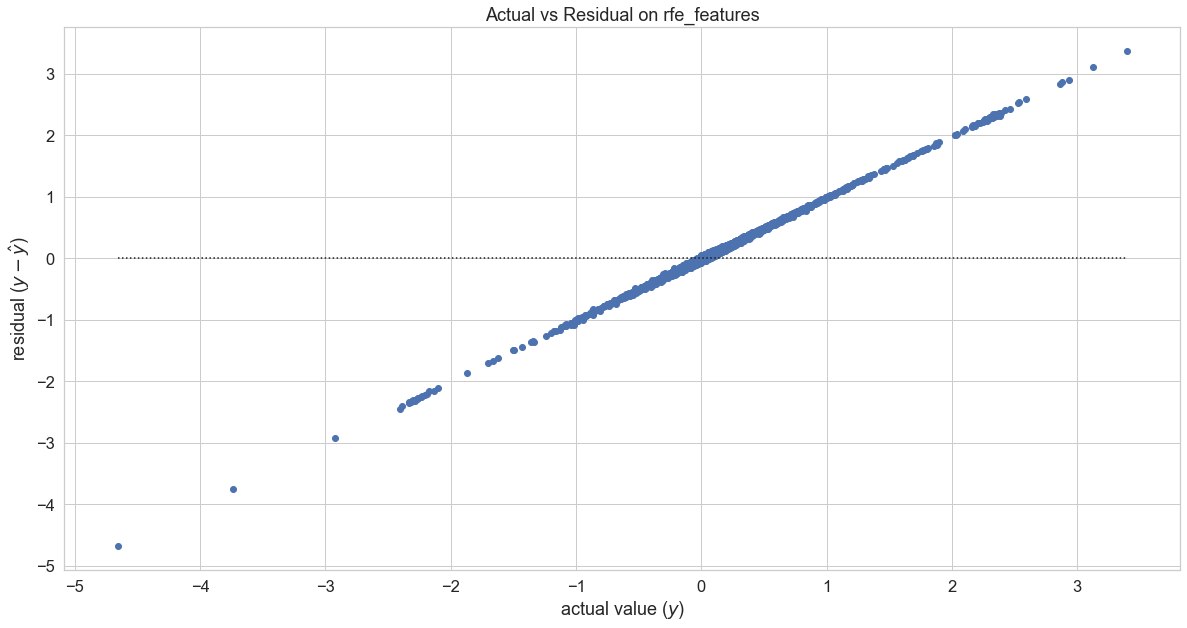

In [105]:
# Residual plot
explore.plot_residuals(y_train, lm_pred_rfe1, 'rfe_features')

#### Takeaway
- RFE selected features are only marginally outperforming SelectKBest features, and both are only marginally outperforming the baseline. 
- When log error is positive, our model is predicting it to be quite a bit higher than it actually is.
- When log error is negative, our model is predicting it to be even more negative than it actually is.

### MODEL 3: LinearRegression + Polynomial Features (3rd Degree), Features = skb_features

In [106]:
# Transform X_train_scaled_skb to cubed values.

pf = PolynomialFeatures(degree=3)
X_train_scaled_cubed_skb = pf.fit_transform(X_train_scaled_skb)

In [107]:
# Create lm_cubed object

lm_cubed1 = LinearRegression()

In [108]:
# Fit X_train_scaled_cubed_skb, predict and compute the rmse

lm_cubed_skb1 = lm_cubed1.fit(X_train_scaled_cubed_skb, y_train) # Fit the model
lm_cubed_pred_skb1 = lm_cubed_skb1.predict(X_train_scaled_cubed_skb) # Predict the target
lm_cubed_rmse_skb1 = math.sqrt(mean_squared_error(y_train, lm_cubed_pred_skb1)) # Calculate error

print('Model 3: Linear Regression plus Polynomial Features (3rd Degree) with SelectKBest Features')
print(f'Root Mean Squared Error: {lm_cubed_rmse_skb1}')

Model 3: Linear Regression plus Polynomial Features (3rd Degree) with SelectKBest Features
Root Mean Squared Error: 0.16233408972442337


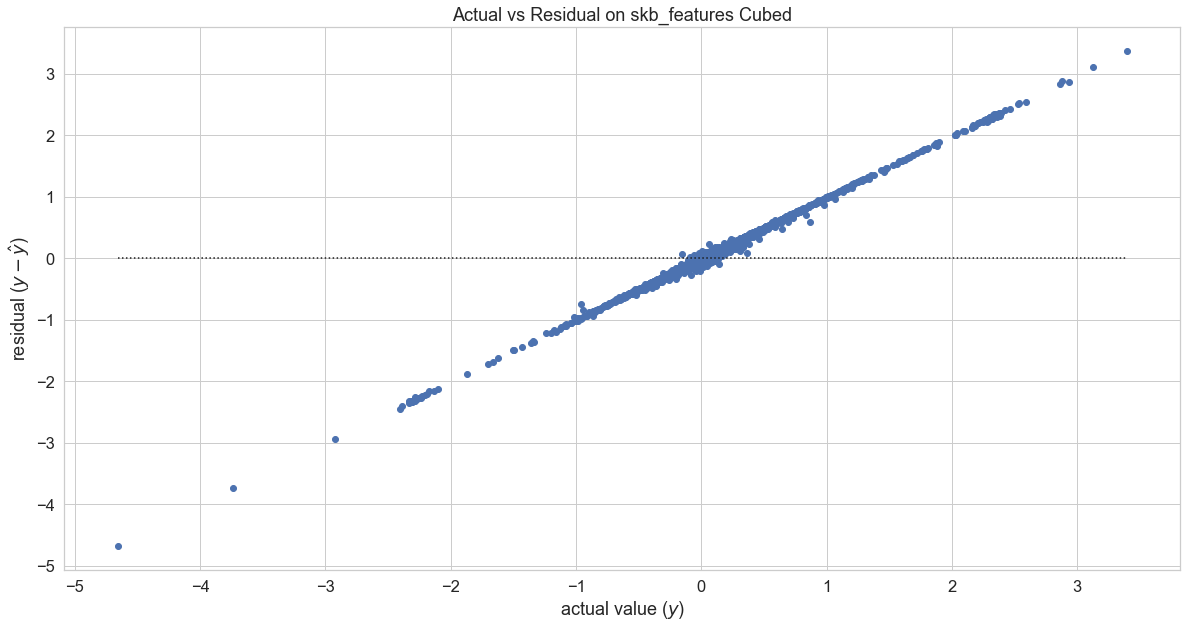

In [109]:
# Residual plot
explore.plot_residuals(y_train, lm_cubed_pred_skb1, 'skb_features Cubed')

#### Takeaway 
- This is the best model thus far. It is performing similar to the other models.

### MODEL 4: LinearRegression (fit_intercept=False) + Polynomial Features (3rd Degree), Features = skb_features

In [110]:
# Create lm_cubed object

lm_cubed2 = LinearRegression(fit_intercept=False)

In [111]:
# Fit X_train_scaled_cubed_skb, predict and compute the rmse

lm_cubed_skb2 = lm_cubed2.fit(X_train_scaled_cubed_skb, y_train) # Fit the model
lm_cubed_pred_skb2 = lm_cubed_skb2.predict(X_train_scaled_cubed_skb) # Predict the target
lm_cubed_rmse_skb2 = math.sqrt(mean_squared_error(y_train, lm_cubed_pred_skb2)) # Calculate error

print('Model 4: Linear Regression plus Polynomial Features (3rd Degree) with SelectKBest Features')
print(f'Root Mean Squared Error: {lm_cubed_rmse_skb2}')

Model 4: Linear Regression plus Polynomial Features (3rd Degree) with SelectKBest Features
Root Mean Squared Error: 0.16233238583093304


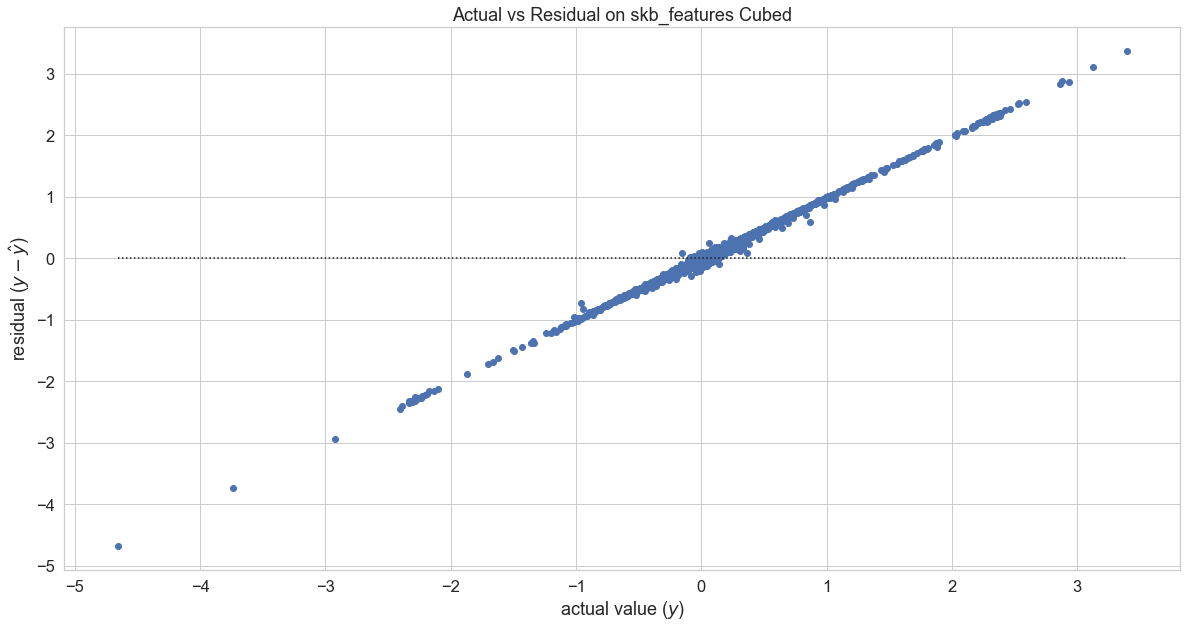

In [112]:
# Residual plot
explore.plot_residuals(y_train, lm_cubed_pred_skb2, 'skb_features Cubed')

#### Takeaways
- This model trends like the other models, but changing the hyperparameter managed to improve the RMSE slightly

### MODEL 5: LinearRegression (fit_intercept=False) + Polynomial Features (3rd Degree), Features = rfe_features

In [113]:
# Transform X_train_scaled_rfe to cubed values.
pf = PolynomialFeatures(degree=3)
X_train_scaled_cubed_rfe = pf.fit_transform(X_train_scaled_rfe)

In [114]:
# Create lm_cubed object

lm_cubed3 = LinearRegression(fit_intercept=False)

In [115]:
# Fit X_train_scaled_cubed_rfe, predict and compute the rmse

lm_cubed_rfe1 = lm_cubed3.fit(X_train_scaled_cubed_rfe, y_train) # Fit the model
lm_cubed_pred_rfe1 = lm_cubed_rfe1.predict(X_train_scaled_cubed_rfe) # Predict the target
lm_cubed_rmse_rfe1 = math.sqrt(mean_squared_error(y_train, lm_cubed_pred_rfe1)) # Calculate error

print('Model 5: Linear Regression plus Polynomial Features (3rd Degree) with SelectKBest Features')
print(f'Root Mean Squared Error: {lm_cubed_rmse_rfe1}')

Model 5: Linear Regression plus Polynomial Features (3rd Degree) with SelectKBest Features
Root Mean Squared Error: 0.1621106188272155


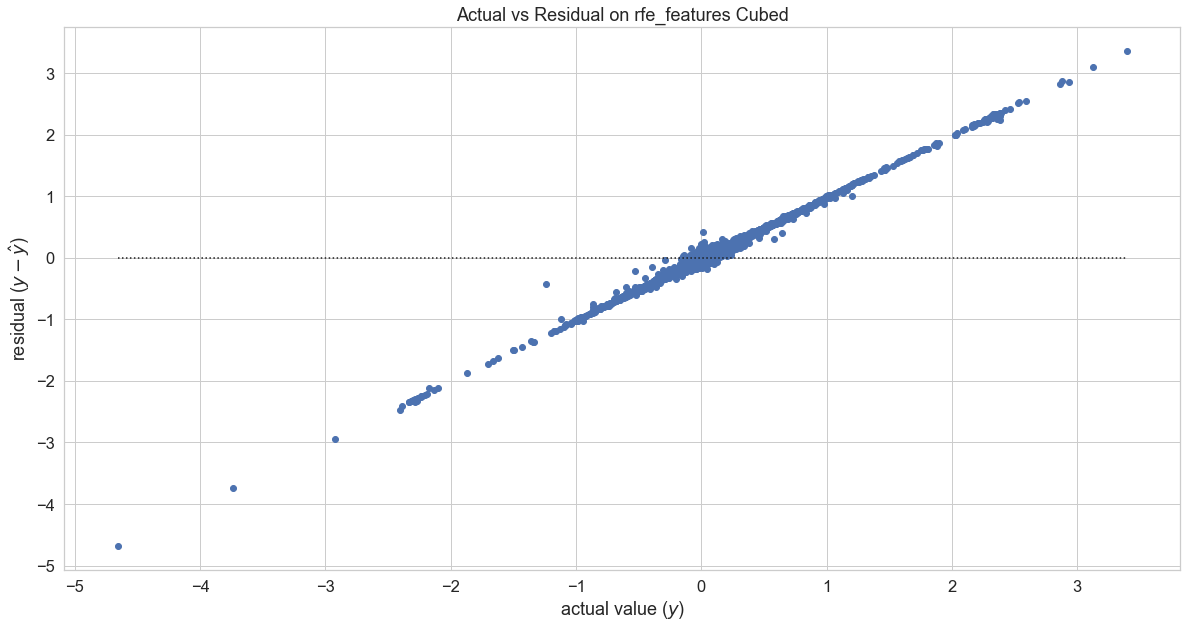

In [116]:
# Residual plot
explore.plot_residuals(y_train, lm_cubed_pred_rfe1, 'rfe_features Cubed')

#### Takeaways:
- This is the best performing model thus far, though overall it still only marginally beats baseline
- It follows the same overall pattern as the previous models

### Summary of Model Performance on Train Data Set

In [117]:
rmse_values = [baseline_rmse, lm_rmse_skb1, lm_rmse_rfe1, lm_cubed_rmse_skb1, lm_cubed_rmse_skb2, lm_cubed_rmse_rfe1]
rmse_index = ['baseline_rmse', 'lm_rmse_skb1', 'lm_rmse_rfe1', 'lm_cubed_rmse_skb1', 'lm_cubed_rmse_skb2', 'lm_cubed_rmse_rfe1']
rmse = pd.DataFrame(rmse_values, index=rmse_index, columns=['Train_RMSE'])
rmse.sort_values(by='Train_RMSE')

,Train_RMSE
lm_cubed_rmse_rfe1,0.162111
lm_cubed_rmse_skb2,0.162332
lm_cubed_rmse_skb1,0.162334
lm_rmse_rfe1,0.162513
lm_rmse_skb1,0.162578
baseline_rmse,0.162808


## Validate Top 2 Models
To check for overfitting, we will evaluate the top 2 models on our validate data

### MODEL 4: LinearRegression (fit_intercept=False) + Polynomial Features (3rd Degree), Features = skb_features

In [118]:
# Create validate dataframe with only features selected by SelectKBest
X_validate_scaled_skb = X_validate_scaled[skb_features]

# Transform X_validate_scaled_rfe features to cubed values
pf = PolynomialFeatures(degree=3)
X_validate_scaled_cubed_skb = pf.fit_transform(X_validate_scaled_skb)

In [119]:
# Transform X_validate_scaled_cubed_skb, predict and compute the rmse

lm_cubed_validate_pred_skb = lm_cubed_skb2.predict(X_validate_scaled_cubed_skb) # Predict the target
lm_cubed_validate_rmse_skb = math.sqrt(mean_squared_error(y_validate, lm_cubed_validate_pred_skb)) # Calculate error

print('Model 4: Linear Regression plus Polynomial Features (3rd Degree) with SelectKBest Features')
print(f'Root Mean Squared Error: {lm_cubed_validate_rmse_skb}')

Model 4: Linear Regression plus Polynomial Features (3rd Degree) with SelectKBest Features
Root Mean Squared Error: 0.17185058208476256


### MODEL 5: LinearRegression (fit_intercept=False) + Polynomial Features (3rd Degree), Features = rfe_features

In [120]:
# Create validate dataframe with only features selected by RFE
X_validate_scaled_rfe = X_validate_scaled[rfe_features]

# Transform X_validate_scaled_rfe features to cubed values
pf = PolynomialFeatures(degree=3)
X_validate_scaled_cubed_rfe = pf.fit_transform(X_validate_scaled_rfe)

In [121]:
# Transform X_validate_scaled_cubed_rfe, predict and compute the rmse

lm_cubed_validate_pred_rfe = lm_cubed_rfe1.predict(X_validate_scaled_cubed_rfe) # Predict the target
lm_cubed_validate_rmse_rfe = math.sqrt(mean_squared_error(y_validate, lm_cubed_validate_pred_rfe)) # Calculate error

print('Model 4: Linear Regression plus Polynomial Features (3rd Degree) with SelectKBest Features')
print(f'Root Mean Squared Error: {lm_cubed_validate_rmse_rfe}')

Model 4: Linear Regression plus Polynomial Features (3rd Degree) with SelectKBest Features
Root Mean Squared Error: 0.17146745717277953


### Baseline Performance on Validate

In [123]:
baseline_validate_rmse = explore.validate_rmse(y_train, y_validate)
print(f'Baseline root mean squared error on validate set: {baseline_validate_rmse}')

Baseline root mean squared error on validate set: 0.17164071841500306


### Summary of Validate Performance

In [124]:
rmse_values = [baseline_validate_rmse, lm_cubed_validate_rmse_skb, lm_cubed_validate_rmse_rfe]
rmse_index = ['baseline_validate_rmse', 'lm_cubed_validate_rmse_skb', 'lm_cubed_validate_rmse_rfe']
rmse = pd.DataFrame(rmse_values, index=rmse_index, columns=['Validate_RMSE'])
rmse.sort_values(by='Validate_RMSE')

,Validate_RMSE
lm_cubed_validate_rmse_rfe,0.171467
baseline_validate_rmse,0.171641
lm_cubed_validate_rmse_skb,0.171851


#### Takeaways:
It does not appear that we have overfit our data too much and the Linear Regression Model using 3rd Degree Polynomial Features with Features selected by RFE is outperforming the baseline model.

# Testing the Top Model 

### LinearRegression (fit_intercept=False) + Polynomial Features (3rd Degree), Features = rfe_features

In [125]:
# Create test dataframe with only features selected by RFE
X_test_scaled_rfe = X_test_scaled[rfe_features]

# Transform X_test_scaled_rfe features to cubed values
pf = PolynomialFeatures(degree=3)
X_test_scaled_cubed_rfe = pf.fit_transform(X_test_scaled_rfe)

In [126]:
# Transform X_test_scaled_cubed_rfe, predict and compute the rmse

lm_cubed_test_pred_rfe = lm_cubed_rfe1.predict(X_test_scaled_cubed_rfe) # Predict the target
lm_cubed_test_rmse_rfe = math.sqrt(mean_squared_error(y_test, lm_cubed_test_pred_rfe)) # Calculate error

print('Model 4: Linear Regression plus Polynomial Features (3rd Degree) with SelectKBest Features')
print(f'Root Mean Squared Error: {lm_cubed_test_rmse_rfe}')

Model 4: Linear Regression plus Polynomial Features (3rd Degree) with SelectKBest Features
Root Mean Squared Error: 0.17079252214701598


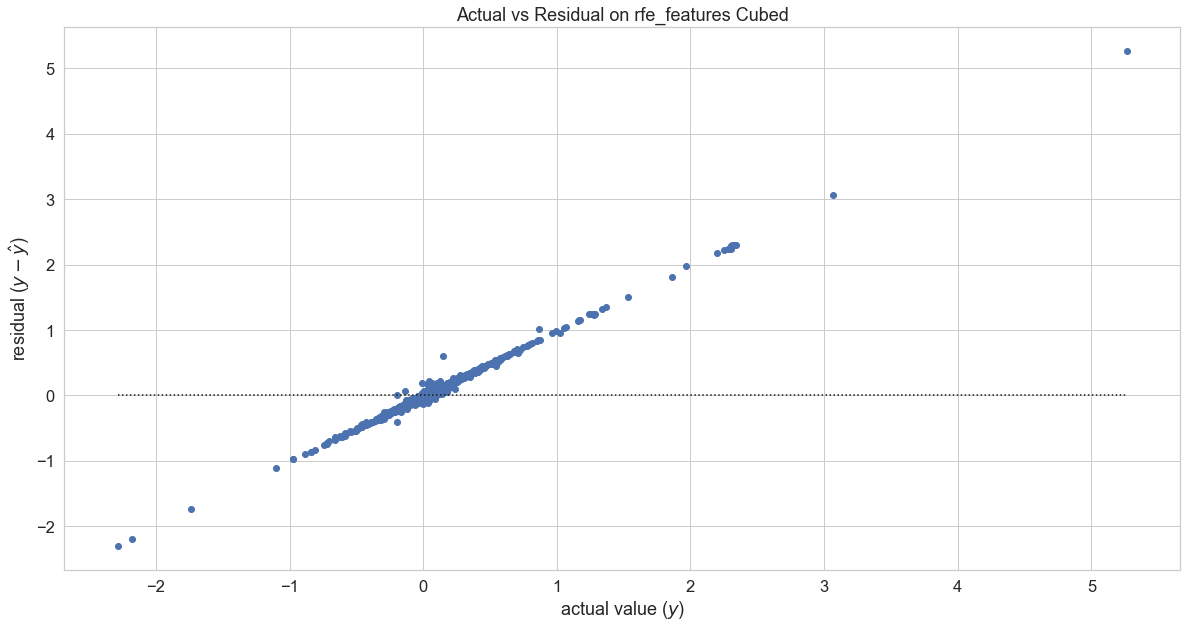

In [127]:
# Residual plot
explore.plot_residuals(y_test, lm_cubed_test_pred_rfe, 'rfe_features Cubed')

#### Baseline Performance on Test Data Set

In [128]:
baseline_test_rmse = explore.test_rmse(y_train, y_test)
print(f'Baseline root mean squared error on test set: {baseline_test_rmse}')

Baseline root mean squared error on test set: 0.17087142737725938


### Summary of Model Performance on Test

In [129]:
rmse_values = [baseline_test_rmse, lm_cubed_test_rmse_rfe]
rmse_index = ['baseline_test_rmse', 'lm_cubed_test_rmse_rfe']
rmse = pd.DataFrame(rmse_values, index=rmse_index, columns=['Test_RMSE'])
rmse.sort_values(by='Test_RMSE')

,Test_RMSE
lm_cubed_test_rmse_rfe,0.170793
baseline_test_rmse,0.170871


# Conclusion

In [130]:
baseline_test_rmse - lm_cubed_test_rmse_rfe

7.89052302433979e-05

The final model outperformed baseline. Though the reduction in root mean squared error was small, the features that were selected were supported through statistical analysis. Nevertheless, the impact of this model is negligible. To create a meaningful change in the Zillow Zestimate, we will need to further explore opportunities to better predict log error. 

Its possible that log error is being driven by factors that are not being captured by the data. Excessive null values in several features necessitated the elimination of valuable information. 

Its also highly likely that the simplistic model suggested here is not robust enough to adequately capture the differences between these properties. Additional feature engineering, alternate feature selection, and changes to hyperparameters may result in a better model, but it is suspected that for meaningful improvement to be achieved, the selected algorithm will need to be more sophisticated. 